### this script is trying to apply VAE to session-wise functional connectivity patterns

* functional connectivity patterns are derived from AAL atlas with 116 ROIs (with some NAN values)
* for 48 subjects, each 7 sessions by default, with 5 missing sessions
* implemented a fully connected layer + relu network


### main findings so far

* clearly captured individual FC profile in embedding space
* my logic of searching real TMS effect (compared with sham) was to calculate the mean euclidean distance between the null and each sham/real point in embedding space, and compare the difference of the distance
* promising trend: distance between null and real is greater than distance between null and sham
* tried further splitting based on stimloc (aOFC vs pOFC) but did not find differential patterns


In [76]:
import numpy as np
import nibabel as nib
import pandas as pd
import os
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.io import loadmat
from scipy.spatial.distance import euclidean
from scipy.stats import ttest_rel, wilcoxon

In [77]:
from models import VAE, CVAE # import functions 
from train_utils import train_vae, loss_function
from data_utils import load_all_fc_data, preprocess_for_torch

# Auto-Reload for Fast Iteration
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [78]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from tqdm import tqdm # progress bar

In [79]:
from sklearn.feature_selection import SelectPercentile, f_classif
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GroupKFold
from sklearn.manifold import TSNE
import umap.umap_ as umap

In [80]:
sub_cond_path = '/Users/liuq13/NODEAP_scripts/ProcessedData/SubConds.xlsx'
base_nifti_folder = '/Volumes/X9Pro/NODEAP/FuncConn_AAL'

# Load and preprocess
all_corr_data, all_tms_type, all_subject_id, all_stimloc = load_all_fc_data(sub_cond_path, 
                                                               base_nifti_folder, 
                                                               mat_filename='conn_matrix.mat')
X_tensor = preprocess_for_torch(all_corr_data)
dataset = TensorDataset(X_tensor)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

[WARN] File not found: /Volumes/X9Pro/NODEAP/FuncConn_AAL/NODEAP_30/S3D2/conn_matrix.mat
[WARN] File not found: /Volumes/X9Pro/NODEAP/FuncConn_AAL/NODEAP_44/S1D1/conn_matrix.mat
[WARN] File not found: /Volumes/X9Pro/NODEAP/FuncConn_AAL/NODEAP_83/S3D1/conn_matrix.mat
[WARN] File not found: /Volumes/X9Pro/NODEAP/FuncConn_AAL/NODEAP_87/D0/conn_matrix.mat
[WARN] File not found: /Volumes/X9Pro/NODEAP/FuncConn_AAL/NODEAP_88/D0/conn_matrix.mat
Columns with NaN: 229 / 6670


In [81]:
# Set up model, optimizer, and device
input_dim = X_tensor.shape[1]
latent_dim = 10
NUM_EPOCH = 500
LR = 3e-4
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = VAE(input_dim=input_dim, latent_dim=latent_dim)
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
total_loss_hist, recon_loss_hist, kld_loss_hist = train_vae(model, dataloader, optimizer, device=device, epochs=500)

Epoch 1/500: 100%|█████████████████████████████| 11/11 [00:00<00:00, 115.00it/s]


Epoch 1, Loss: 6796.5629, Recon: 6795.4592, KL: 1.1037


Epoch 2/500: 100%|█████████████████████████████| 11/11 [00:00<00:00, 131.16it/s]


Epoch 2, Loss: 6631.2366, Recon: 6627.7030, KL: 3.5336


Epoch 3/500: 100%|█████████████████████████████| 11/11 [00:00<00:00, 135.32it/s]


Epoch 3, Loss: 6506.5132, Recon: 6500.6509, KL: 5.8623


Epoch 4/500: 100%|██████████████████████████████| 11/11 [00:00<00:00, 83.95it/s]


Epoch 4, Loss: 6360.3262, Recon: 6350.4690, KL: 9.8571


Epoch 5/500: 100%|█████████████████████████████| 11/11 [00:00<00:00, 137.25it/s]


Epoch 5, Loss: 6104.4307, Recon: 6087.9126, KL: 16.5181


Epoch 6/500: 100%|█████████████████████████████| 11/11 [00:00<00:00, 134.07it/s]


Epoch 6, Loss: 5836.8981, Recon: 5815.5078, KL: 21.3903


Epoch 7/500: 100%|█████████████████████████████| 11/11 [00:00<00:00, 136.48it/s]


Epoch 7, Loss: 5597.0598, Recon: 5571.4380, KL: 25.6218


Epoch 8/500: 100%|█████████████████████████████| 11/11 [00:00<00:00, 126.65it/s]


Epoch 8, Loss: 5395.0347, Recon: 5365.2308, KL: 29.8038


Epoch 9/500: 100%|█████████████████████████████| 11/11 [00:00<00:00, 143.01it/s]


Epoch 9, Loss: 5216.7822, Recon: 5184.2399, KL: 32.5422


Epoch 10/500: 100%|████████████████████████████| 11/11 [00:00<00:00, 139.82it/s]


Epoch 10, Loss: 5069.9280, Recon: 5034.6591, KL: 35.2689


Epoch 11/500: 100%|████████████████████████████| 11/11 [00:00<00:00, 145.42it/s]


Epoch 11, Loss: 4948.3967, Recon: 4911.2167, KL: 37.1800


Epoch 12/500: 100%|████████████████████████████| 11/11 [00:00<00:00, 140.14it/s]


Epoch 12, Loss: 4838.4168, Recon: 4798.9849, KL: 39.4319


Epoch 13/500: 100%|████████████████████████████| 11/11 [00:00<00:00, 142.43it/s]


Epoch 13, Loss: 4739.6013, Recon: 4697.6421, KL: 41.9591


Epoch 14/500: 100%|████████████████████████████| 11/11 [00:00<00:00, 142.84it/s]


Epoch 14, Loss: 4649.8777, Recon: 4606.3446, KL: 43.5332


Epoch 15/500: 100%|████████████████████████████| 11/11 [00:00<00:00, 130.78it/s]


Epoch 15, Loss: 4571.2511, Recon: 4525.3087, KL: 45.9424


Epoch 16/500: 100%|████████████████████████████| 11/11 [00:00<00:00, 138.02it/s]


Epoch 16, Loss: 4485.8901, Recon: 4439.0046, KL: 46.8855


Epoch 17/500: 100%|████████████████████████████| 11/11 [00:00<00:00, 123.48it/s]


Epoch 17, Loss: 4417.0536, Recon: 4367.2752, KL: 49.7785


Epoch 18/500: 100%|████████████████████████████| 11/11 [00:00<00:00, 132.81it/s]


Epoch 18, Loss: 4349.3139, Recon: 4298.3024, KL: 51.0115


Epoch 19/500: 100%|████████████████████████████| 11/11 [00:00<00:00, 142.93it/s]


Epoch 19, Loss: 4291.3752, Recon: 4238.0777, KL: 53.2976


Epoch 20/500: 100%|████████████████████████████| 11/11 [00:00<00:00, 134.57it/s]


Epoch 20, Loss: 4238.5539, Recon: 4183.2408, KL: 55.3130


Epoch 21/500: 100%|████████████████████████████| 11/11 [00:00<00:00, 123.21it/s]


Epoch 21, Loss: 4192.0759, Recon: 4135.2490, KL: 56.8268


Epoch 22/500: 100%|████████████████████████████| 11/11 [00:00<00:00, 123.69it/s]


Epoch 22, Loss: 4141.1437, Recon: 4082.0107, KL: 59.1330


Epoch 23/500: 100%|████████████████████████████| 11/11 [00:00<00:00, 136.23it/s]


Epoch 23, Loss: 4089.2878, Recon: 4028.6436, KL: 60.6441


Epoch 24/500: 100%|█████████████████████████████| 11/11 [00:00<00:00, 93.75it/s]


Epoch 24, Loss: 4049.7214, Recon: 3986.9213, KL: 62.8001


Epoch 25/500: 100%|████████████████████████████| 11/11 [00:00<00:00, 139.18it/s]


Epoch 25, Loss: 3997.4445, Recon: 3932.8986, KL: 64.5460


Epoch 26/500: 100%|████████████████████████████| 11/11 [00:00<00:00, 138.78it/s]


Epoch 26, Loss: 3951.4238, Recon: 3884.8486, KL: 66.5752


Epoch 27/500: 100%|████████████████████████████| 11/11 [00:00<00:00, 153.20it/s]


Epoch 27, Loss: 3904.9376, Recon: 3837.1979, KL: 67.7397


Epoch 28/500: 100%|████████████████████████████| 11/11 [00:00<00:00, 155.95it/s]


Epoch 28, Loss: 3866.9775, Recon: 3797.2225, KL: 69.7550


Epoch 29/500: 100%|████████████████████████████| 11/11 [00:00<00:00, 145.52it/s]


Epoch 29, Loss: 3828.4965, Recon: 3757.4647, KL: 71.0318


Epoch 30/500: 100%|████████████████████████████| 11/11 [00:00<00:00, 149.55it/s]


Epoch 30, Loss: 3799.5711, Recon: 3726.7993, KL: 72.7718


Epoch 31/500: 100%|████████████████████████████| 11/11 [00:00<00:00, 129.18it/s]


Epoch 31, Loss: 3763.6715, Recon: 3689.5693, KL: 74.1021


Epoch 32/500: 100%|████████████████████████████| 11/11 [00:00<00:00, 141.14it/s]


Epoch 32, Loss: 3731.8875, Recon: 3656.7253, KL: 75.1623


Epoch 33/500: 100%|████████████████████████████| 11/11 [00:00<00:00, 153.76it/s]


Epoch 33, Loss: 3698.8028, Recon: 3620.5644, KL: 78.2384


Epoch 34/500: 100%|████████████████████████████| 11/11 [00:00<00:00, 152.64it/s]


Epoch 34, Loss: 3667.2845, Recon: 3589.6609, KL: 77.6236


Epoch 35/500: 100%|████████████████████████████| 11/11 [00:00<00:00, 155.70it/s]


Epoch 35, Loss: 3639.6973, Recon: 3558.6613, KL: 81.0359


Epoch 36/500: 100%|████████████████████████████| 11/11 [00:00<00:00, 141.47it/s]


Epoch 36, Loss: 3606.7585, Recon: 3526.5024, KL: 80.2561


Epoch 37/500: 100%|████████████████████████████| 11/11 [00:00<00:00, 158.16it/s]


Epoch 37, Loss: 3579.0777, Recon: 3496.1721, KL: 82.9056


Epoch 38/500: 100%|████████████████████████████| 11/11 [00:00<00:00, 144.89it/s]


Epoch 38, Loss: 3551.7333, Recon: 3468.8845, KL: 82.8489


Epoch 39/500: 100%|████████████████████████████| 11/11 [00:00<00:00, 132.73it/s]


Epoch 39, Loss: 3528.6444, Recon: 3443.7897, KL: 84.8548


Epoch 40/500: 100%|████████████████████████████| 11/11 [00:00<00:00, 165.94it/s]


Epoch 40, Loss: 3505.0298, Recon: 3420.0321, KL: 84.9977


Epoch 41/500: 100%|████████████████████████████| 11/11 [00:00<00:00, 165.74it/s]


Epoch 41, Loss: 3484.3211, Recon: 3397.0406, KL: 87.2806


Epoch 42/500: 100%|████████████████████████████| 11/11 [00:00<00:00, 128.20it/s]


Epoch 42, Loss: 3462.5834, Recon: 3375.9625, KL: 86.6209


Epoch 43/500: 100%|████████████████████████████| 11/11 [00:00<00:00, 138.24it/s]


Epoch 43, Loss: 3443.1188, Recon: 3353.6896, KL: 89.4292


Epoch 44/500: 100%|████████████████████████████| 11/11 [00:00<00:00, 149.57it/s]


Epoch 44, Loss: 3423.1444, Recon: 3334.8996, KL: 88.2448


Epoch 45/500: 100%|█████████████████████████████| 11/11 [00:00<00:00, 85.44it/s]


Epoch 45, Loss: 3400.8840, Recon: 3309.5655, KL: 91.3185


Epoch 46/500: 100%|████████████████████████████| 11/11 [00:00<00:00, 109.95it/s]


Epoch 46, Loss: 3393.3135, Recon: 3301.6984, KL: 91.6151


Epoch 47/500: 100%|████████████████████████████| 11/11 [00:00<00:00, 129.92it/s]


Epoch 47, Loss: 3364.4368, Recon: 3271.4891, KL: 92.9477


Epoch 48/500: 100%|████████████████████████████| 11/11 [00:00<00:00, 133.22it/s]


Epoch 48, Loss: 3382.7528, Recon: 3290.7589, KL: 91.9939


Epoch 49/500: 100%|████████████████████████████| 11/11 [00:00<00:00, 156.65it/s]


Epoch 49, Loss: 3333.4225, Recon: 3239.8827, KL: 93.5397


Epoch 50/500: 100%|████████████████████████████| 11/11 [00:00<00:00, 135.22it/s]


Epoch 50, Loss: 3314.3172, Recon: 3218.9653, KL: 95.3519


Epoch 51/500: 100%|████████████████████████████| 11/11 [00:00<00:00, 148.81it/s]


Epoch 51, Loss: 3295.3734, Recon: 3199.9794, KL: 95.3940


Epoch 52/500: 100%|████████████████████████████| 11/11 [00:00<00:00, 157.64it/s]


Epoch 52, Loss: 3276.0706, Recon: 3180.2671, KL: 95.8035


Epoch 53/500: 100%|████████████████████████████| 11/11 [00:00<00:00, 147.35it/s]


Epoch 53, Loss: 3258.8125, Recon: 3162.5088, KL: 96.3037


Epoch 54/500: 100%|████████████████████████████| 11/11 [00:00<00:00, 108.20it/s]


Epoch 54, Loss: 3240.3643, Recon: 3142.4361, KL: 97.9282


Epoch 55/500: 100%|████████████████████████████| 11/11 [00:00<00:00, 145.35it/s]


Epoch 55, Loss: 3226.5819, Recon: 3128.5020, KL: 98.0800


Epoch 56/500: 100%|████████████████████████████| 11/11 [00:00<00:00, 142.19it/s]


Epoch 56, Loss: 3216.1214, Recon: 3117.5061, KL: 98.6153


Epoch 57/500: 100%|████████████████████████████| 11/11 [00:00<00:00, 160.09it/s]


Epoch 57, Loss: 3199.9818, Recon: 3100.7297, KL: 99.2520


Epoch 58/500: 100%|████████████████████████████| 11/11 [00:00<00:00, 152.35it/s]


Epoch 58, Loss: 3188.2573, Recon: 3088.2142, KL: 100.0431


Epoch 59/500: 100%|████████████████████████████| 11/11 [00:00<00:00, 158.60it/s]


Epoch 59, Loss: 3173.4004, Recon: 3073.5358, KL: 99.8646


Epoch 60/500: 100%|████████████████████████████| 11/11 [00:00<00:00, 162.78it/s]


Epoch 60, Loss: 3161.7382, Recon: 3060.7093, KL: 101.0289


Epoch 61/500: 100%|████████████████████████████| 11/11 [00:00<00:00, 146.86it/s]


Epoch 61, Loss: 3150.0135, Recon: 3048.5006, KL: 101.5129


Epoch 62/500: 100%|████████████████████████████| 11/11 [00:00<00:00, 158.69it/s]


Epoch 62, Loss: 3135.5883, Recon: 3034.0060, KL: 101.5823


Epoch 63/500: 100%|████████████████████████████| 11/11 [00:00<00:00, 157.51it/s]


Epoch 63, Loss: 3125.2141, Recon: 3022.7404, KL: 102.4736


Epoch 64/500: 100%|████████████████████████████| 11/11 [00:00<00:00, 153.46it/s]


Epoch 64, Loss: 3111.8708, Recon: 3008.7767, KL: 103.0940


Epoch 65/500: 100%|████████████████████████████| 11/11 [00:00<00:00, 160.99it/s]


Epoch 65, Loss: 3101.2032, Recon: 2998.6208, KL: 102.5825


Epoch 66/500: 100%|████████████████████████████| 11/11 [00:00<00:00, 163.56it/s]


Epoch 66, Loss: 3091.3271, Recon: 2987.7653, KL: 103.5618


Epoch 67/500: 100%|████████████████████████████| 11/11 [00:00<00:00, 134.63it/s]


Epoch 67, Loss: 3082.6186, Recon: 2978.8154, KL: 103.8032


Epoch 68/500: 100%|████████████████████████████| 11/11 [00:00<00:00, 154.74it/s]


Epoch 68, Loss: 3074.6635, Recon: 2970.3272, KL: 104.3363


Epoch 69/500: 100%|████████████████████████████| 11/11 [00:00<00:00, 164.90it/s]


Epoch 69, Loss: 3060.7251, Recon: 2955.8767, KL: 104.8485


Epoch 70/500: 100%|████████████████████████████| 11/11 [00:00<00:00, 159.89it/s]


Epoch 70, Loss: 3050.7787, Recon: 2945.9863, KL: 104.7924


Epoch 71/500: 100%|████████████████████████████| 11/11 [00:00<00:00, 155.26it/s]


Epoch 71, Loss: 3043.9354, Recon: 2938.4597, KL: 105.4756


Epoch 72/500: 100%|████████████████████████████| 11/11 [00:00<00:00, 134.35it/s]


Epoch 72, Loss: 3036.9209, Recon: 2932.0426, KL: 104.8783


Epoch 73/500: 100%|████████████████████████████| 11/11 [00:00<00:00, 143.56it/s]


Epoch 73, Loss: 3025.8863, Recon: 2920.0432, KL: 105.8431


Epoch 74/500: 100%|████████████████████████████| 11/11 [00:00<00:00, 140.23it/s]


Epoch 74, Loss: 3017.8082, Recon: 2911.5209, KL: 106.2873


Epoch 75/500: 100%|████████████████████████████| 11/11 [00:00<00:00, 134.22it/s]


Epoch 75, Loss: 3009.7405, Recon: 2903.5652, KL: 106.1754


Epoch 76/500: 100%|████████████████████████████| 11/11 [00:00<00:00, 118.91it/s]


Epoch 76, Loss: 2995.7410, Recon: 2889.0164, KL: 106.7246


Epoch 77/500: 100%|████████████████████████████| 11/11 [00:00<00:00, 158.26it/s]


Epoch 77, Loss: 2984.9613, Recon: 2878.2541, KL: 106.7072


Epoch 78/500: 100%|████████████████████████████| 11/11 [00:00<00:00, 155.08it/s]


Epoch 78, Loss: 2981.1106, Recon: 2874.5225, KL: 106.5881


Epoch 79/500: 100%|████████████████████████████| 11/11 [00:00<00:00, 157.55it/s]


Epoch 79, Loss: 2971.1446, Recon: 2863.8230, KL: 107.3217


Epoch 80/500: 100%|█████████████████████████████| 11/11 [00:00<00:00, 97.75it/s]


Epoch 80, Loss: 2962.5171, Recon: 2855.0313, KL: 107.4858


Epoch 81/500: 100%|████████████████████████████| 11/11 [00:00<00:00, 145.72it/s]


Epoch 81, Loss: 2959.3425, Recon: 2851.3911, KL: 107.9514


Epoch 82/500: 100%|████████████████████████████| 11/11 [00:00<00:00, 153.79it/s]


Epoch 82, Loss: 2947.5759, Recon: 2839.6007, KL: 107.9752


Epoch 83/500: 100%|████████████████████████████| 11/11 [00:00<00:00, 150.44it/s]


Epoch 83, Loss: 2939.6942, Recon: 2831.6184, KL: 108.0759


Epoch 84/500: 100%|████████████████████████████| 11/11 [00:00<00:00, 155.90it/s]


Epoch 84, Loss: 2930.9252, Recon: 2822.9035, KL: 108.0217


Epoch 85/500: 100%|████████████████████████████| 11/11 [00:00<00:00, 126.62it/s]


Epoch 85, Loss: 2921.7677, Recon: 2813.3234, KL: 108.4443


Epoch 86/500: 100%|████████████████████████████| 11/11 [00:00<00:00, 112.42it/s]


Epoch 86, Loss: 2915.1491, Recon: 2806.6844, KL: 108.4647


Epoch 87/500: 100%|████████████████████████████| 11/11 [00:00<00:00, 134.18it/s]


Epoch 87, Loss: 2904.6934, Recon: 2796.4272, KL: 108.2662


Epoch 88/500: 100%|████████████████████████████| 11/11 [00:00<00:00, 119.40it/s]


Epoch 88, Loss: 2899.9006, Recon: 2791.0835, KL: 108.8171


Epoch 89/500: 100%|████████████████████████████| 11/11 [00:00<00:00, 157.74it/s]


Epoch 89, Loss: 2898.5168, Recon: 2788.7140, KL: 109.8028


Epoch 90/500: 100%|████████████████████████████| 11/11 [00:00<00:00, 153.07it/s]


Epoch 90, Loss: 2891.3861, Recon: 2782.0928, KL: 109.2933


Epoch 91/500: 100%|████████████████████████████| 11/11 [00:00<00:00, 139.72it/s]


Epoch 91, Loss: 2881.9144, Recon: 2772.2017, KL: 109.7127


Epoch 92/500: 100%|████████████████████████████| 11/11 [00:00<00:00, 113.38it/s]


Epoch 92, Loss: 2880.2286, Recon: 2770.5593, KL: 109.6693


Epoch 93/500: 100%|████████████████████████████| 11/11 [00:00<00:00, 125.96it/s]


Epoch 93, Loss: 2873.1775, Recon: 2764.1530, KL: 109.0245


Epoch 94/500: 100%|████████████████████████████| 11/11 [00:00<00:00, 153.47it/s]


Epoch 94, Loss: 2867.0511, Recon: 2757.3260, KL: 109.7251


Epoch 95/500: 100%|████████████████████████████| 11/11 [00:00<00:00, 136.32it/s]


Epoch 95, Loss: 2862.5472, Recon: 2752.6787, KL: 109.8685


Epoch 96/500: 100%|█████████████████████████████| 11/11 [00:00<00:00, 70.46it/s]


Epoch 96, Loss: 2860.1260, Recon: 2749.4338, KL: 110.6922


Epoch 97/500: 100%|████████████████████████████| 11/11 [00:00<00:00, 100.58it/s]


Epoch 97, Loss: 2853.6952, Recon: 2743.5375, KL: 110.1577


Epoch 98/500: 100%|████████████████████████████| 11/11 [00:00<00:00, 152.33it/s]


Epoch 98, Loss: 2849.9848, Recon: 2738.6779, KL: 111.3070


Epoch 99/500: 100%|████████████████████████████| 11/11 [00:00<00:00, 156.65it/s]


Epoch 99, Loss: 2841.3332, Recon: 2731.9821, KL: 109.3511


Epoch 100/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 144.12it/s]


Epoch 100, Loss: 2836.4147, Recon: 2724.8663, KL: 111.5484


Epoch 101/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 151.77it/s]


Epoch 101, Loss: 2828.8484, Recon: 2719.1366, KL: 109.7118


Epoch 102/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 149.87it/s]


Epoch 102, Loss: 2823.4309, Recon: 2712.5163, KL: 110.9147


Epoch 103/500: 100%|████████████████████████████| 11/11 [00:00<00:00, 91.69it/s]


Epoch 103, Loss: 2817.3049, Recon: 2707.3266, KL: 109.9784


Epoch 104/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 124.22it/s]


Epoch 104, Loss: 2811.8184, Recon: 2700.1171, KL: 111.7014


Epoch 105/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 154.60it/s]


Epoch 105, Loss: 2805.6782, Recon: 2694.5616, KL: 111.1167


Epoch 106/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 149.31it/s]


Epoch 106, Loss: 2801.8420, Recon: 2690.7149, KL: 111.1271


Epoch 107/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 101.32it/s]


Epoch 107, Loss: 2792.2992, Recon: 2681.1328, KL: 111.1664


Epoch 108/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 129.88it/s]


Epoch 108, Loss: 2787.6157, Recon: 2676.8661, KL: 110.7496


Epoch 109/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 162.99it/s]


Epoch 109, Loss: 2785.0052, Recon: 2673.7379, KL: 111.2673


Epoch 110/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 158.29it/s]


Epoch 110, Loss: 2778.5096, Recon: 2667.3032, KL: 111.2064


Epoch 111/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 142.51it/s]


Epoch 111, Loss: 2770.8514, Recon: 2659.4970, KL: 111.3544


Epoch 112/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 116.70it/s]


Epoch 112, Loss: 2768.7613, Recon: 2657.0738, KL: 111.6875


Epoch 113/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 147.03it/s]


Epoch 113, Loss: 2763.3584, Recon: 2652.0746, KL: 111.2838


Epoch 114/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 156.51it/s]


Epoch 114, Loss: 2759.3060, Recon: 2648.0590, KL: 111.2470


Epoch 115/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 144.39it/s]


Epoch 115, Loss: 2757.7067, Recon: 2646.3818, KL: 111.3249


Epoch 116/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 157.37it/s]


Epoch 116, Loss: 2748.1010, Recon: 2636.7634, KL: 111.3376


Epoch 117/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 158.37it/s]


Epoch 117, Loss: 2747.8443, Recon: 2636.1524, KL: 111.6919


Epoch 118/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 158.24it/s]


Epoch 118, Loss: 2745.9535, Recon: 2634.7860, KL: 111.1675


Epoch 119/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 155.94it/s]


Epoch 119, Loss: 2739.3918, Recon: 2627.2256, KL: 112.1662


Epoch 120/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 162.52it/s]


Epoch 120, Loss: 2737.6395, Recon: 2625.3293, KL: 112.3102


Epoch 121/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 155.86it/s]


Epoch 121, Loss: 2731.2749, Recon: 2619.4478, KL: 111.8270


Epoch 122/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 141.74it/s]


Epoch 122, Loss: 2726.5281, Recon: 2614.2951, KL: 112.2330


Epoch 123/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 130.54it/s]


Epoch 123, Loss: 2721.0654, Recon: 2609.1794, KL: 111.8859


Epoch 124/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 144.27it/s]


Epoch 124, Loss: 2717.0883, Recon: 2604.9918, KL: 112.0965


Epoch 125/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 154.67it/s]


Epoch 125, Loss: 2712.6920, Recon: 2600.2272, KL: 112.4647


Epoch 126/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 155.37it/s]


Epoch 126, Loss: 2710.3991, Recon: 2598.2911, KL: 112.1079


Epoch 127/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 155.05it/s]


Epoch 127, Loss: 2708.6288, Recon: 2596.7658, KL: 111.8630


Epoch 128/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 141.57it/s]


Epoch 128, Loss: 2703.8355, Recon: 2590.7075, KL: 113.1280


Epoch 129/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 157.25it/s]


Epoch 129, Loss: 2704.2564, Recon: 2593.2416, KL: 111.0148


Epoch 130/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 151.25it/s]


Epoch 130, Loss: 2702.2734, Recon: 2588.7074, KL: 113.5660


Epoch 131/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 156.72it/s]


Epoch 131, Loss: 2697.0497, Recon: 2584.9850, KL: 112.0647


Epoch 132/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 158.63it/s]


Epoch 132, Loss: 2693.0282, Recon: 2580.2680, KL: 112.7602


Epoch 133/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 163.34it/s]


Epoch 133, Loss: 2691.4648, Recon: 2579.2479, KL: 112.2169


Epoch 134/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 143.05it/s]


Epoch 134, Loss: 2687.6221, Recon: 2574.5171, KL: 113.1051


Epoch 135/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 149.67it/s]


Epoch 135, Loss: 2681.6813, Recon: 2569.4397, KL: 112.2416


Epoch 136/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 115.38it/s]


Epoch 136, Loss: 2675.2224, Recon: 2562.9155, KL: 112.3069


Epoch 137/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 139.73it/s]


Epoch 137, Loss: 2670.5633, Recon: 2557.1877, KL: 113.3755


Epoch 138/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 127.82it/s]


Epoch 138, Loss: 2668.0936, Recon: 2555.4342, KL: 112.6593


Epoch 139/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 127.93it/s]


Epoch 139, Loss: 2663.5469, Recon: 2550.5272, KL: 113.0197


Epoch 140/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 113.02it/s]


Epoch 140, Loss: 2658.1491, Recon: 2544.6670, KL: 113.4821


Epoch 141/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 124.05it/s]


Epoch 141, Loss: 2656.1347, Recon: 2543.6008, KL: 112.5338


Epoch 142/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 130.11it/s]


Epoch 142, Loss: 2651.2831, Recon: 2537.7079, KL: 113.5752


Epoch 143/500: 100%|████████████████████████████| 11/11 [00:00<00:00, 96.67it/s]


Epoch 143, Loss: 2648.1842, Recon: 2535.4149, KL: 112.7693


Epoch 144/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 100.17it/s]


Epoch 144, Loss: 2641.8072, Recon: 2527.6110, KL: 114.1962


Epoch 145/500: 100%|████████████████████████████| 11/11 [00:00<00:00, 91.74it/s]


Epoch 145, Loss: 2638.0572, Recon: 2524.8046, KL: 113.2526


Epoch 146/500: 100%|████████████████████████████| 11/11 [00:00<00:00, 80.58it/s]


Epoch 146, Loss: 2638.3937, Recon: 2524.2882, KL: 114.1055


Epoch 147/500: 100%|████████████████████████████| 11/11 [00:00<00:00, 81.08it/s]


Epoch 147, Loss: 2630.7050, Recon: 2517.8337, KL: 112.8713


Epoch 148/500: 100%|████████████████████████████| 11/11 [00:00<00:00, 75.11it/s]


Epoch 148, Loss: 2630.9759, Recon: 2517.1960, KL: 113.7798


Epoch 149/500: 100%|████████████████████████████| 11/11 [00:00<00:00, 82.45it/s]


Epoch 149, Loss: 2629.0206, Recon: 2516.1868, KL: 112.8338


Epoch 150/500: 100%|████████████████████████████| 11/11 [00:00<00:00, 75.83it/s]


Epoch 150, Loss: 2625.1862, Recon: 2511.5030, KL: 113.6832


Epoch 151/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 107.73it/s]


Epoch 151, Loss: 2620.9097, Recon: 2507.7674, KL: 113.1423


Epoch 152/500: 100%|████████████████████████████| 11/11 [00:00<00:00, 98.33it/s]


Epoch 152, Loss: 2620.0565, Recon: 2506.4778, KL: 113.5787


Epoch 153/500: 100%|████████████████████████████| 11/11 [00:00<00:00, 75.10it/s]


Epoch 153, Loss: 2613.5472, Recon: 2499.9264, KL: 113.6207


Epoch 154/500: 100%|████████████████████████████| 11/11 [00:00<00:00, 83.95it/s]


Epoch 154, Loss: 2607.8586, Recon: 2493.5262, KL: 114.3324


Epoch 155/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 115.60it/s]


Epoch 155, Loss: 2606.4073, Recon: 2492.7141, KL: 113.6932


Epoch 156/500: 100%|████████████████████████████| 11/11 [00:00<00:00, 91.78it/s]


Epoch 156, Loss: 2603.7878, Recon: 2489.9123, KL: 113.8754


Epoch 157/500: 100%|████████████████████████████| 11/11 [00:00<00:00, 94.19it/s]


Epoch 157, Loss: 2599.6293, Recon: 2486.1852, KL: 113.4441


Epoch 158/500: 100%|████████████████████████████| 11/11 [00:00<00:00, 61.58it/s]


Epoch 158, Loss: 2595.0946, Recon: 2481.0923, KL: 114.0022


Epoch 159/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 100.93it/s]


Epoch 159, Loss: 2588.5757, Recon: 2474.5271, KL: 114.0486


Epoch 160/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 121.05it/s]


Epoch 160, Loss: 2583.0030, Recon: 2468.9250, KL: 114.0780


Epoch 161/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 119.25it/s]


Epoch 161, Loss: 2581.2727, Recon: 2467.8274, KL: 113.4453


Epoch 162/500: 100%|████████████████████████████| 11/11 [00:00<00:00, 92.03it/s]


Epoch 162, Loss: 2579.3488, Recon: 2465.2247, KL: 114.1241


Epoch 163/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 107.08it/s]


Epoch 163, Loss: 2578.7459, Recon: 2464.5257, KL: 114.2202


Epoch 164/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 118.76it/s]


Epoch 164, Loss: 2579.3359, Recon: 2465.5273, KL: 113.8085


Epoch 165/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 122.12it/s]


Epoch 165, Loss: 2572.3026, Recon: 2458.0127, KL: 114.2899


Epoch 166/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 116.69it/s]


Epoch 166, Loss: 2569.2115, Recon: 2455.0385, KL: 114.1729


Epoch 167/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 128.05it/s]


Epoch 167, Loss: 2570.1298, Recon: 2450.5455, KL: 119.5844


Epoch 168/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 136.81it/s]


Epoch 168, Loss: 2569.8858, Recon: 2456.5679, KL: 113.3179


Epoch 169/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 131.60it/s]


Epoch 169, Loss: 2564.2389, Recon: 2449.0291, KL: 115.2097


Epoch 170/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 129.50it/s]


Epoch 170, Loss: 2561.5097, Recon: 2447.3238, KL: 114.1859


Epoch 171/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 115.63it/s]


Epoch 171, Loss: 2558.4695, Recon: 2443.6631, KL: 114.8064


Epoch 172/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 102.21it/s]


Epoch 172, Loss: 2554.9809, Recon: 2440.5018, KL: 114.4791


Epoch 173/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 108.47it/s]


Epoch 173, Loss: 2549.7226, Recon: 2434.8333, KL: 114.8893


Epoch 174/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 155.41it/s]


Epoch 174, Loss: 2549.2444, Recon: 2435.3931, KL: 113.8512


Epoch 175/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 139.06it/s]


Epoch 175, Loss: 2542.1854, Recon: 2427.7374, KL: 114.4481


Epoch 176/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 158.22it/s]


Epoch 176, Loss: 2540.3913, Recon: 2426.1206, KL: 114.2707


Epoch 177/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 164.93it/s]


Epoch 177, Loss: 2536.4056, Recon: 2421.5895, KL: 114.8161


Epoch 178/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 147.94it/s]


Epoch 178, Loss: 2536.1114, Recon: 2421.2643, KL: 114.8472


Epoch 179/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 145.22it/s]


Epoch 179, Loss: 2534.8829, Recon: 2420.2935, KL: 114.5894


Epoch 180/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 157.43it/s]


Epoch 180, Loss: 2533.8410, Recon: 2419.1847, KL: 114.6563


Epoch 181/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 155.74it/s]


Epoch 181, Loss: 2528.0719, Recon: 2413.3908, KL: 114.6811


Epoch 182/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 159.45it/s]


Epoch 182, Loss: 2524.7887, Recon: 2410.3193, KL: 114.4694


Epoch 183/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 153.41it/s]


Epoch 183, Loss: 2522.6500, Recon: 2407.8411, KL: 114.8089


Epoch 184/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 158.10it/s]


Epoch 184, Loss: 2518.7904, Recon: 2404.0936, KL: 114.6968


Epoch 185/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 152.51it/s]


Epoch 185, Loss: 2515.0122, Recon: 2399.7671, KL: 115.2451


Epoch 186/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 146.38it/s]


Epoch 186, Loss: 2513.5576, Recon: 2398.8082, KL: 114.7494


Epoch 187/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 154.92it/s]


Epoch 187, Loss: 2510.2915, Recon: 2395.3814, KL: 114.9101


Epoch 188/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 105.90it/s]


Epoch 188, Loss: 2510.0993, Recon: 2393.8628, KL: 116.2364


Epoch 189/500: 100%|████████████████████████████| 11/11 [00:00<00:00, 88.77it/s]


Epoch 189, Loss: 2504.8132, Recon: 2389.5804, KL: 115.2328


Epoch 190/500: 100%|████████████████████████████| 11/11 [00:00<00:00, 85.03it/s]


Epoch 190, Loss: 2502.6995, Recon: 2386.8951, KL: 115.8043


Epoch 191/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 106.73it/s]


Epoch 191, Loss: 2502.4186, Recon: 2387.2365, KL: 115.1821


Epoch 192/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 101.36it/s]


Epoch 192, Loss: 2500.1790, Recon: 2384.7331, KL: 115.4459


Epoch 193/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 108.10it/s]


Epoch 193, Loss: 2495.1976, Recon: 2379.8668, KL: 115.3308


Epoch 194/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 106.65it/s]


Epoch 194, Loss: 2492.7133, Recon: 2376.8481, KL: 115.8652


Epoch 195/500: 100%|████████████████████████████| 11/11 [00:00<00:00, 96.28it/s]


Epoch 195, Loss: 2487.8329, Recon: 2372.3649, KL: 115.4679


Epoch 196/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 102.14it/s]


Epoch 196, Loss: 2485.4166, Recon: 2369.6065, KL: 115.8101


Epoch 197/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 110.35it/s]


Epoch 197, Loss: 2481.2638, Recon: 2365.4277, KL: 115.8361


Epoch 198/500: 100%|████████████████████████████| 11/11 [00:00<00:00, 83.51it/s]


Epoch 198, Loss: 2479.5235, Recon: 2363.3671, KL: 116.1563


Epoch 199/500: 100%|████████████████████████████| 11/11 [00:00<00:00, 96.25it/s]


Epoch 199, Loss: 2476.5873, Recon: 2360.9204, KL: 115.6669


Epoch 200/500: 100%|████████████████████████████| 11/11 [00:00<00:00, 88.57it/s]


Epoch 200, Loss: 2473.4051, Recon: 2357.6331, KL: 115.7720


Epoch 201/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 106.64it/s]


Epoch 201, Loss: 2471.3799, Recon: 2355.5527, KL: 115.8272


Epoch 202/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 100.87it/s]


Epoch 202, Loss: 2468.3509, Recon: 2352.2761, KL: 116.0749


Epoch 203/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 125.81it/s]


Epoch 203, Loss: 2463.7666, Recon: 2347.9228, KL: 115.8439


Epoch 204/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 116.45it/s]


Epoch 204, Loss: 2464.1745, Recon: 2348.1683, KL: 116.0062


Epoch 205/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 115.06it/s]


Epoch 205, Loss: 2457.3728, Recon: 2341.4082, KL: 115.9646


Epoch 206/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 115.25it/s]


Epoch 206, Loss: 2457.2226, Recon: 2340.7530, KL: 116.4695


Epoch 207/500: 100%|████████████████████████████| 11/11 [00:00<00:00, 76.53it/s]


Epoch 207, Loss: 2454.1599, Recon: 2337.9619, KL: 116.1980


Epoch 208/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 124.37it/s]


Epoch 208, Loss: 2449.6316, Recon: 2332.5463, KL: 117.0853


Epoch 209/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 124.37it/s]


Epoch 209, Loss: 2447.8846, Recon: 2331.9204, KL: 115.9642


Epoch 210/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 102.82it/s]


Epoch 210, Loss: 2447.7297, Recon: 2331.6483, KL: 116.0814


Epoch 211/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 121.08it/s]


Epoch 211, Loss: 2448.1970, Recon: 2331.7138, KL: 116.4831


Epoch 212/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 112.88it/s]


Epoch 212, Loss: 2445.1936, Recon: 2328.7554, KL: 116.4382


Epoch 213/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 109.97it/s]


Epoch 213, Loss: 2444.1492, Recon: 2327.3180, KL: 116.8312


Epoch 214/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 116.63it/s]


Epoch 214, Loss: 2442.1398, Recon: 2325.2239, KL: 116.9159


Epoch 215/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 124.40it/s]


Epoch 215, Loss: 2441.1133, Recon: 2323.6010, KL: 117.5123


Epoch 216/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 103.90it/s]


Epoch 216, Loss: 2442.1891, Recon: 2325.8909, KL: 116.2982


Epoch 217/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 118.37it/s]


Epoch 217, Loss: 2436.8526, Recon: 2319.3623, KL: 117.4903


Epoch 218/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 102.59it/s]


Epoch 218, Loss: 2436.7531, Recon: 2319.9119, KL: 116.8412


Epoch 219/500: 100%|████████████████████████████| 11/11 [00:00<00:00, 81.70it/s]


Epoch 219, Loss: 2435.1017, Recon: 2317.7637, KL: 117.3380


Epoch 220/500: 100%|████████████████████████████| 11/11 [00:00<00:00, 93.92it/s]


Epoch 220, Loss: 2431.0166, Recon: 2314.2509, KL: 116.7658


Epoch 221/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 112.18it/s]


Epoch 221, Loss: 2427.7294, Recon: 2310.3414, KL: 117.3879


Epoch 222/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 107.08it/s]


Epoch 222, Loss: 2424.7841, Recon: 2307.6593, KL: 117.1248


Epoch 223/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 121.49it/s]


Epoch 223, Loss: 2420.8136, Recon: 2303.5435, KL: 117.2700


Epoch 224/500: 100%|████████████████████████████| 11/11 [00:00<00:00, 79.56it/s]


Epoch 224, Loss: 2419.5773, Recon: 2301.5774, KL: 117.9998


Epoch 225/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 116.42it/s]


Epoch 225, Loss: 2417.6584, Recon: 2300.0430, KL: 117.6154


Epoch 226/500: 100%|████████████████████████████| 11/11 [00:00<00:00, 98.75it/s]


Epoch 226, Loss: 2416.8431, Recon: 2299.2424, KL: 117.6007


Epoch 227/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 116.96it/s]


Epoch 227, Loss: 2410.2362, Recon: 2292.4983, KL: 117.7380


Epoch 228/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 112.24it/s]


Epoch 228, Loss: 2408.9629, Recon: 2292.1301, KL: 116.8328


Epoch 229/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 123.34it/s]


Epoch 229, Loss: 2405.1111, Recon: 2287.3666, KL: 117.7446


Epoch 230/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 105.78it/s]


Epoch 230, Loss: 2400.1161, Recon: 2282.1373, KL: 117.9787


Epoch 231/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 114.95it/s]


Epoch 231, Loss: 2395.9894, Recon: 2278.0321, KL: 117.9573


Epoch 232/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 112.51it/s]


Epoch 232, Loss: 2400.1370, Recon: 2282.2169, KL: 117.9200


Epoch 233/500: 100%|████████████████████████████| 11/11 [00:00<00:00, 97.04it/s]


Epoch 233, Loss: 2399.0418, Recon: 2280.5838, KL: 118.4579


Epoch 234/500: 100%|████████████████████████████| 11/11 [00:00<00:00, 79.55it/s]


Epoch 234, Loss: 2401.0668, Recon: 2283.0654, KL: 118.0015


Epoch 235/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 114.26it/s]


Epoch 235, Loss: 2398.8304, Recon: 2280.4954, KL: 118.3350


Epoch 236/500: 100%|████████████████████████████| 11/11 [00:00<00:00, 98.72it/s]


Epoch 236, Loss: 2395.0783, Recon: 2276.4187, KL: 118.6595


Epoch 237/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 121.87it/s]


Epoch 237, Loss: 2390.1142, Recon: 2271.9993, KL: 118.1148


Epoch 238/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 115.83it/s]


Epoch 238, Loss: 2385.9662, Recon: 2266.9792, KL: 118.9870


Epoch 239/500: 100%|████████████████████████████| 11/11 [00:00<00:00, 96.76it/s]


Epoch 239, Loss: 2384.0895, Recon: 2264.7962, KL: 119.2933


Epoch 240/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 121.99it/s]


Epoch 240, Loss: 2381.6665, Recon: 2263.2792, KL: 118.3872


Epoch 241/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 128.86it/s]


Epoch 241, Loss: 2379.4896, Recon: 2260.8411, KL: 118.6485


Epoch 242/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 118.28it/s]


Epoch 242, Loss: 2379.3016, Recon: 2260.6289, KL: 118.6727


Epoch 243/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 127.13it/s]


Epoch 243, Loss: 2372.1628, Recon: 2252.8413, KL: 119.3215


Epoch 244/500: 100%|████████████████████████████| 11/11 [00:00<00:00, 96.34it/s]


Epoch 244, Loss: 2370.4525, Recon: 2251.1607, KL: 119.2918


Epoch 245/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 120.10it/s]


Epoch 245, Loss: 2368.5187, Recon: 2249.3712, KL: 119.1475


Epoch 246/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 106.60it/s]


Epoch 246, Loss: 2363.2200, Recon: 2243.8471, KL: 119.3729


Epoch 247/500: 100%|████████████████████████████| 11/11 [00:00<00:00, 67.54it/s]


Epoch 247, Loss: 2359.8859, Recon: 2240.6704, KL: 119.2155


Epoch 248/500: 100%|████████████████████████████| 11/11 [00:00<00:00, 97.59it/s]


Epoch 248, Loss: 2357.5779, Recon: 2238.4274, KL: 119.1506


Epoch 249/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 103.37it/s]


Epoch 249, Loss: 2355.3356, Recon: 2235.9081, KL: 119.4275


Epoch 250/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 113.80it/s]


Epoch 250, Loss: 2355.3379, Recon: 2236.0484, KL: 119.2895


Epoch 251/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 107.73it/s]


Epoch 251, Loss: 2355.8976, Recon: 2236.3054, KL: 119.5922


Epoch 252/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 104.30it/s]


Epoch 252, Loss: 2353.1812, Recon: 2232.9726, KL: 120.2086


Epoch 253/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 101.35it/s]


Epoch 253, Loss: 2351.5528, Recon: 2231.5158, KL: 120.0371


Epoch 254/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 109.28it/s]


Epoch 254, Loss: 2347.6297, Recon: 2227.3430, KL: 120.2867


Epoch 255/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 117.02it/s]


Epoch 255, Loss: 2345.3791, Recon: 2226.0174, KL: 119.3617


Epoch 256/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 117.80it/s]


Epoch 256, Loss: 2342.0316, Recon: 2221.6436, KL: 120.3881


Epoch 257/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 116.85it/s]


Epoch 257, Loss: 2339.7497, Recon: 2219.3970, KL: 120.3528


Epoch 258/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 120.79it/s]


Epoch 258, Loss: 2336.4071, Recon: 2216.5741, KL: 119.8330


Epoch 259/500: 100%|████████████████████████████| 11/11 [00:00<00:00, 85.63it/s]


Epoch 259, Loss: 2334.3663, Recon: 2214.6822, KL: 119.6841


Epoch 260/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 110.62it/s]


Epoch 260, Loss: 2332.4396, Recon: 2211.8574, KL: 120.5821


Epoch 261/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 110.21it/s]


Epoch 261, Loss: 2331.2742, Recon: 2210.9873, KL: 120.2870


Epoch 262/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 111.30it/s]


Epoch 262, Loss: 2325.1229, Recon: 2204.1446, KL: 120.9783


Epoch 263/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 112.45it/s]


Epoch 263, Loss: 2331.3450, Recon: 2210.3479, KL: 120.9972


Epoch 264/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 115.20it/s]


Epoch 264, Loss: 2325.7395, Recon: 2204.2586, KL: 121.4809


Epoch 265/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 105.66it/s]


Epoch 265, Loss: 2324.4532, Recon: 2203.6257, KL: 120.8276


Epoch 266/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 106.44it/s]


Epoch 266, Loss: 2320.2224, Recon: 2198.9504, KL: 121.2721


Epoch 267/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 110.47it/s]


Epoch 267, Loss: 2318.3886, Recon: 2197.0057, KL: 121.3829


Epoch 268/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 116.93it/s]


Epoch 268, Loss: 2317.1845, Recon: 2196.5193, KL: 120.6652


Epoch 269/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 109.03it/s]


Epoch 269, Loss: 2310.6678, Recon: 2189.4111, KL: 121.2567


Epoch 270/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 117.48it/s]


Epoch 270, Loss: 2310.6122, Recon: 2189.2957, KL: 121.3166


Epoch 271/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 110.12it/s]


Epoch 271, Loss: 2308.8065, Recon: 2186.8074, KL: 121.9991


Epoch 272/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 108.17it/s]


Epoch 272, Loss: 2307.4388, Recon: 2185.9588, KL: 121.4801


Epoch 273/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 116.90it/s]


Epoch 273, Loss: 2301.4952, Recon: 2179.9795, KL: 121.5157


Epoch 274/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 115.43it/s]


Epoch 274, Loss: 2298.7448, Recon: 2176.7393, KL: 122.0055


Epoch 275/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 114.97it/s]


Epoch 275, Loss: 2294.6723, Recon: 2172.9111, KL: 121.7612


Epoch 276/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 120.91it/s]


Epoch 276, Loss: 2294.7137, Recon: 2172.6632, KL: 122.0504


Epoch 277/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 115.43it/s]


Epoch 277, Loss: 2294.9709, Recon: 2172.5357, KL: 122.4353


Epoch 278/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 115.57it/s]


Epoch 278, Loss: 2290.5679, Recon: 2168.3263, KL: 122.2416


Epoch 279/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 117.16it/s]


Epoch 279, Loss: 2286.1857, Recon: 2164.0758, KL: 122.1100


Epoch 280/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 118.81it/s]


Epoch 280, Loss: 2287.6631, Recon: 2165.2014, KL: 122.4617


Epoch 281/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 116.05it/s]


Epoch 281, Loss: 2280.9073, Recon: 2158.3985, KL: 122.5088


Epoch 282/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 104.19it/s]


Epoch 282, Loss: 2280.6683, Recon: 2158.0427, KL: 122.6257


Epoch 283/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 106.65it/s]


Epoch 283, Loss: 2280.0099, Recon: 2157.8093, KL: 122.2006


Epoch 284/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 106.67it/s]


Epoch 284, Loss: 2280.1667, Recon: 2157.3821, KL: 122.7847


Epoch 285/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 107.43it/s]


Epoch 285, Loss: 2278.9919, Recon: 2155.6625, KL: 123.3294


Epoch 286/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 103.45it/s]


Epoch 286, Loss: 2275.5466, Recon: 2152.5898, KL: 122.9567


Epoch 287/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 113.87it/s]


Epoch 287, Loss: 2273.4293, Recon: 2150.0974, KL: 123.3319


Epoch 288/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 111.76it/s]


Epoch 288, Loss: 2273.5470, Recon: 2150.6036, KL: 122.9434


Epoch 289/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 103.48it/s]


Epoch 289, Loss: 2273.0739, Recon: 2149.8968, KL: 123.1771


Epoch 290/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 108.71it/s]


Epoch 290, Loss: 2266.4794, Recon: 2142.4507, KL: 124.0287


Epoch 291/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 122.56it/s]


Epoch 291, Loss: 2265.8322, Recon: 2141.8053, KL: 124.0269


Epoch 292/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 117.11it/s]


Epoch 292, Loss: 2266.7531, Recon: 2143.4941, KL: 123.2590


Epoch 293/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 103.83it/s]


Epoch 293, Loss: 2262.2600, Recon: 2138.3644, KL: 123.8955


Epoch 294/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 110.72it/s]


Epoch 294, Loss: 2261.2385, Recon: 2137.2637, KL: 123.9748


Epoch 295/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 111.15it/s]


Epoch 295, Loss: 2260.6944, Recon: 2136.5439, KL: 124.1505


Epoch 296/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 107.24it/s]


Epoch 296, Loss: 2257.2261, Recon: 2133.8195, KL: 123.4066


Epoch 297/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 114.98it/s]


Epoch 297, Loss: 2255.6713, Recon: 2131.5006, KL: 124.1707


Epoch 298/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 106.54it/s]


Epoch 298, Loss: 2254.2739, Recon: 2130.4200, KL: 123.8540


Epoch 299/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 107.54it/s]


Epoch 299, Loss: 2251.9316, Recon: 2126.9552, KL: 124.9764


Epoch 300/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 111.56it/s]


Epoch 300, Loss: 2250.6861, Recon: 2126.3364, KL: 124.3497


Epoch 301/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 109.33it/s]


Epoch 301, Loss: 2245.5029, Recon: 2121.6054, KL: 123.8975


Epoch 302/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 113.23it/s]


Epoch 302, Loss: 2244.8090, Recon: 2120.0655, KL: 124.7435


Epoch 303/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 113.70it/s]


Epoch 303, Loss: 2243.9016, Recon: 2119.5486, KL: 124.3530


Epoch 304/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 107.58it/s]


Epoch 304, Loss: 2239.5259, Recon: 2114.2031, KL: 125.3228


Epoch 305/500: 100%|████████████████████████████| 11/11 [00:00<00:00, 78.95it/s]


Epoch 305, Loss: 2237.2741, Recon: 2112.2786, KL: 124.9956


Epoch 306/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 106.77it/s]


Epoch 306, Loss: 2234.7853, Recon: 2110.0414, KL: 124.7439


Epoch 307/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 115.80it/s]


Epoch 307, Loss: 2235.0489, Recon: 2109.5238, KL: 125.5250


Epoch 308/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 115.53it/s]


Epoch 308, Loss: 2233.3352, Recon: 2108.4379, KL: 124.8973


Epoch 309/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 104.07it/s]


Epoch 309, Loss: 2229.3366, Recon: 2103.6196, KL: 125.7170


Epoch 310/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 107.52it/s]


Epoch 310, Loss: 2229.4586, Recon: 2104.3696, KL: 125.0890


Epoch 311/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 118.79it/s]


Epoch 311, Loss: 2227.3991, Recon: 2101.7431, KL: 125.6560


Epoch 312/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 108.06it/s]


Epoch 312, Loss: 2226.2220, Recon: 2100.2460, KL: 125.9760


Epoch 313/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 112.62it/s]


Epoch 313, Loss: 2220.1415, Recon: 2094.1229, KL: 126.0186


Epoch 314/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 106.49it/s]


Epoch 314, Loss: 2220.8197, Recon: 2094.9222, KL: 125.8975


Epoch 315/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 113.47it/s]


Epoch 315, Loss: 2222.0763, Recon: 2095.6993, KL: 126.3769


Epoch 316/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 109.30it/s]


Epoch 316, Loss: 2219.8777, Recon: 2093.8092, KL: 126.0685


Epoch 317/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 125.90it/s]


Epoch 317, Loss: 2215.7605, Recon: 2090.0024, KL: 125.7581


Epoch 318/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 113.33it/s]


Epoch 318, Loss: 2210.9742, Recon: 2084.6903, KL: 126.2840


Epoch 319/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 107.01it/s]


Epoch 319, Loss: 2207.0497, Recon: 2080.6571, KL: 126.3926


Epoch 320/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 108.88it/s]


Epoch 320, Loss: 2206.3016, Recon: 2079.3469, KL: 126.9548


Epoch 321/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 108.74it/s]


Epoch 321, Loss: 2203.1879, Recon: 2076.2486, KL: 126.9393


Epoch 322/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 111.58it/s]


Epoch 322, Loss: 2203.3471, Recon: 2076.3878, KL: 126.9592


Epoch 323/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 111.65it/s]


Epoch 323, Loss: 2199.1143, Recon: 2072.5991, KL: 126.5152


Epoch 324/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 119.04it/s]


Epoch 324, Loss: 2201.7700, Recon: 2074.8124, KL: 126.9576


Epoch 325/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 111.47it/s]


Epoch 325, Loss: 2199.2556, Recon: 2071.7529, KL: 127.5027


Epoch 326/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 112.39it/s]


Epoch 326, Loss: 2194.8113, Recon: 2067.7586, KL: 127.0527


Epoch 327/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 112.62it/s]


Epoch 327, Loss: 2197.9245, Recon: 2070.4871, KL: 127.4373


Epoch 328/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 112.64it/s]


Epoch 328, Loss: 2197.2799, Recon: 2069.1573, KL: 128.1226


Epoch 329/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 124.03it/s]


Epoch 329, Loss: 2193.9060, Recon: 2065.8030, KL: 128.1030


Epoch 330/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 113.08it/s]


Epoch 330, Loss: 2187.4682, Recon: 2059.2773, KL: 128.1909


Epoch 331/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 114.54it/s]


Epoch 331, Loss: 2186.5825, Recon: 2058.8841, KL: 127.6984


Epoch 332/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 107.77it/s]


Epoch 332, Loss: 2181.8488, Recon: 2053.2426, KL: 128.6062


Epoch 333/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 114.73it/s]


Epoch 333, Loss: 2180.9761, Recon: 2052.8319, KL: 128.1441


Epoch 334/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 106.96it/s]


Epoch 334, Loss: 2177.7737, Recon: 2049.2805, KL: 128.4931


Epoch 335/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 109.96it/s]


Epoch 335, Loss: 2175.1370, Recon: 2046.7202, KL: 128.4168


Epoch 336/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 113.33it/s]


Epoch 336, Loss: 2173.3337, Recon: 2044.1145, KL: 129.2192


Epoch 337/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 111.77it/s]


Epoch 337, Loss: 2169.6228, Recon: 2040.5046, KL: 129.1183


Epoch 338/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 107.42it/s]


Epoch 338, Loss: 2167.7756, Recon: 2038.7415, KL: 129.0341


Epoch 339/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 117.01it/s]


Epoch 339, Loss: 2166.8771, Recon: 2037.7069, KL: 129.1702


Epoch 340/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 111.44it/s]


Epoch 340, Loss: 2169.5311, Recon: 2040.1298, KL: 129.4013


Epoch 341/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 112.24it/s]


Epoch 341, Loss: 2165.0181, Recon: 2035.5263, KL: 129.4919


Epoch 342/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 123.07it/s]


Epoch 342, Loss: 2161.4278, Recon: 2031.1725, KL: 130.2553


Epoch 343/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 108.69it/s]


Epoch 343, Loss: 2159.5422, Recon: 2030.0845, KL: 129.4578


Epoch 344/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 112.02it/s]


Epoch 344, Loss: 2159.6716, Recon: 2029.9612, KL: 129.7104


Epoch 345/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 107.45it/s]


Epoch 345, Loss: 2157.7949, Recon: 2027.7114, KL: 130.0835


Epoch 346/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 121.64it/s]


Epoch 346, Loss: 2155.0228, Recon: 2024.8964, KL: 130.1265


Epoch 347/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 116.25it/s]


Epoch 347, Loss: 2153.6269, Recon: 2024.1492, KL: 129.4777


Epoch 348/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 105.34it/s]


Epoch 348, Loss: 2153.9160, Recon: 2024.2259, KL: 129.6902


Epoch 349/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 111.10it/s]


Epoch 349, Loss: 2150.8184, Recon: 2020.5502, KL: 130.2682


Epoch 350/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 110.83it/s]


Epoch 350, Loss: 2146.6394, Recon: 2016.1765, KL: 130.4629


Epoch 351/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 113.42it/s]


Epoch 351, Loss: 2142.9826, Recon: 2013.2046, KL: 129.7780


Epoch 352/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 107.04it/s]


Epoch 352, Loss: 2143.2049, Recon: 2012.3907, KL: 130.8142


Epoch 353/500: 100%|████████████████████████████| 11/11 [00:00<00:00, 82.04it/s]


Epoch 353, Loss: 2142.0019, Recon: 2011.5679, KL: 130.4340


Epoch 354/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 104.12it/s]


Epoch 354, Loss: 2138.6388, Recon: 2007.6308, KL: 131.0080


Epoch 355/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 110.25it/s]


Epoch 355, Loss: 2135.9690, Recon: 2005.0772, KL: 130.8918


Epoch 356/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 118.17it/s]


Epoch 356, Loss: 2133.3936, Recon: 2002.3154, KL: 131.0782


Epoch 357/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 111.62it/s]


Epoch 357, Loss: 2132.5664, Recon: 2001.6234, KL: 130.9430


Epoch 358/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 111.59it/s]


Epoch 358, Loss: 2132.6004, Recon: 2000.6998, KL: 131.9005


Epoch 359/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 110.15it/s]


Epoch 359, Loss: 2130.6419, Recon: 1999.6987, KL: 130.9432


Epoch 360/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 114.70it/s]


Epoch 360, Loss: 2131.1427, Recon: 1999.7690, KL: 131.3737


Epoch 361/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 107.16it/s]


Epoch 361, Loss: 2130.1789, Recon: 1997.7134, KL: 132.4655


Epoch 362/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 117.52it/s]


Epoch 362, Loss: 2128.3259, Recon: 1996.2977, KL: 132.0282


Epoch 363/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 107.78it/s]


Epoch 363, Loss: 2128.2059, Recon: 1996.4340, KL: 131.7719


Epoch 364/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 111.85it/s]


Epoch 364, Loss: 2125.5168, Recon: 1992.8375, KL: 132.6793


Epoch 365/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 115.03it/s]


Epoch 365, Loss: 2126.4044, Recon: 1994.5733, KL: 131.8311


Epoch 366/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 111.94it/s]


Epoch 366, Loss: 2121.9025, Recon: 1989.5842, KL: 132.3183


Epoch 367/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 107.60it/s]


Epoch 367, Loss: 2119.7744, Recon: 1987.0710, KL: 132.7035


Epoch 368/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 106.70it/s]


Epoch 368, Loss: 2118.1415, Recon: 1985.2016, KL: 132.9399


Epoch 369/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 118.21it/s]


Epoch 369, Loss: 2118.4359, Recon: 1985.2805, KL: 133.1555


Epoch 370/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 114.26it/s]


Epoch 370, Loss: 2117.7813, Recon: 1985.1725, KL: 132.6087


Epoch 371/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 114.41it/s]


Epoch 371, Loss: 2115.6817, Recon: 1983.3358, KL: 132.3460


Epoch 372/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 108.48it/s]


Epoch 372, Loss: 2116.2649, Recon: 1982.9894, KL: 133.2754


Epoch 373/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 109.04it/s]


Epoch 373, Loss: 2110.1529, Recon: 1977.0520, KL: 133.1010


Epoch 374/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 107.09it/s]


Epoch 374, Loss: 2108.4571, Recon: 1974.6561, KL: 133.8010


Epoch 375/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 109.24it/s]


Epoch 375, Loss: 2102.5284, Recon: 1969.0080, KL: 133.5204


Epoch 376/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 108.73it/s]


Epoch 376, Loss: 2100.1499, Recon: 1966.4164, KL: 133.7335


Epoch 377/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 115.18it/s]


Epoch 377, Loss: 2103.5198, Recon: 1970.0261, KL: 133.4938


Epoch 378/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 110.37it/s]


Epoch 378, Loss: 2095.7398, Recon: 1962.5375, KL: 133.2024


Epoch 379/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 126.13it/s]


Epoch 379, Loss: 2097.4512, Recon: 1963.7943, KL: 133.6569


Epoch 380/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 114.23it/s]


Epoch 380, Loss: 2093.5736, Recon: 1959.6757, KL: 133.8979


Epoch 381/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 117.75it/s]


Epoch 381, Loss: 2094.2691, Recon: 1960.4364, KL: 133.8328


Epoch 382/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 107.93it/s]


Epoch 382, Loss: 2094.4687, Recon: 1959.5231, KL: 134.9456


Epoch 383/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 107.47it/s]


Epoch 383, Loss: 2091.4926, Recon: 1956.4353, KL: 135.0574


Epoch 384/500: 100%|████████████████████████████| 11/11 [00:00<00:00, 92.56it/s]


Epoch 384, Loss: 2086.2449, Recon: 1951.3912, KL: 134.8537


Epoch 385/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 106.54it/s]


Epoch 385, Loss: 2086.1411, Recon: 1951.6054, KL: 134.5357


Epoch 386/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 105.21it/s]


Epoch 386, Loss: 2079.1086, Recon: 1944.4975, KL: 134.6111


Epoch 387/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 105.04it/s]


Epoch 387, Loss: 2077.8916, Recon: 1943.3482, KL: 134.5435


Epoch 388/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 117.86it/s]


Epoch 388, Loss: 2077.3177, Recon: 1941.9673, KL: 135.3504


Epoch 389/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 123.25it/s]


Epoch 389, Loss: 2075.9761, Recon: 1941.0327, KL: 134.9434


Epoch 390/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 114.42it/s]


Epoch 390, Loss: 2071.5761, Recon: 1935.6532, KL: 135.9229


Epoch 391/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 112.39it/s]


Epoch 391, Loss: 2070.0031, Recon: 1934.9356, KL: 135.0674


Epoch 392/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 118.88it/s]


Epoch 392, Loss: 2068.6197, Recon: 1933.4446, KL: 135.1751


Epoch 393/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 112.91it/s]


Epoch 393, Loss: 2067.6191, Recon: 1931.7903, KL: 135.8288


Epoch 394/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 117.47it/s]


Epoch 394, Loss: 2062.3216, Recon: 1926.4862, KL: 135.8354


Epoch 395/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 121.54it/s]


Epoch 395, Loss: 2063.9975, Recon: 1927.7542, KL: 136.2434


Epoch 396/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 115.97it/s]


Epoch 396, Loss: 2063.6330, Recon: 1927.2944, KL: 136.3387


Epoch 397/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 112.16it/s]


Epoch 397, Loss: 2062.6823, Recon: 1926.2586, KL: 136.4237


Epoch 398/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 130.07it/s]


Epoch 398, Loss: 2058.9237, Recon: 1922.5160, KL: 136.4077


Epoch 399/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 116.92it/s]


Epoch 399, Loss: 2055.6215, Recon: 1919.0978, KL: 136.5236


Epoch 400/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 101.22it/s]


Epoch 400, Loss: 2056.3779, Recon: 1919.7143, KL: 136.6636


Epoch 401/500: 100%|████████████████████████████| 11/11 [00:00<00:00, 86.87it/s]


Epoch 401, Loss: 2056.6994, Recon: 1919.7828, KL: 136.9166


Epoch 402/500: 100%|████████████████████████████| 11/11 [00:00<00:00, 97.92it/s]


Epoch 402, Loss: 2051.8766, Recon: 1914.8093, KL: 137.0673


Epoch 403/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 124.07it/s]


Epoch 403, Loss: 2052.5830, Recon: 1915.6832, KL: 136.8998


Epoch 404/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 124.96it/s]


Epoch 404, Loss: 2054.3253, Recon: 1917.2016, KL: 137.1236


Epoch 405/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 113.47it/s]


Epoch 405, Loss: 2063.6080, Recon: 1926.9958, KL: 136.6122


Epoch 406/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 106.72it/s]


Epoch 406, Loss: 2055.0148, Recon: 1916.4823, KL: 138.5324


Epoch 407/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 110.40it/s]


Epoch 407, Loss: 2049.4963, Recon: 1912.5505, KL: 136.9458


Epoch 408/500: 100%|████████████████████████████| 11/11 [00:00<00:00, 80.32it/s]


Epoch 408, Loss: 2045.7182, Recon: 1908.1028, KL: 137.6154


Epoch 409/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 103.47it/s]


Epoch 409, Loss: 2037.3403, Recon: 1899.5471, KL: 137.7931


Epoch 410/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 122.80it/s]


Epoch 410, Loss: 2035.1330, Recon: 1896.9743, KL: 138.1587


Epoch 411/500: 100%|████████████████████████████| 11/11 [00:00<00:00, 49.44it/s]


Epoch 411, Loss: 2036.7755, Recon: 1898.8723, KL: 137.9033


Epoch 412/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 114.83it/s]


Epoch 412, Loss: 2030.9337, Recon: 1892.5648, KL: 138.3689


Epoch 413/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 117.49it/s]


Epoch 413, Loss: 2035.5268, Recon: 1897.6622, KL: 137.8646


Epoch 414/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 119.81it/s]


Epoch 414, Loss: 2034.6569, Recon: 1896.0097, KL: 138.6472


Epoch 415/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 123.55it/s]


Epoch 415, Loss: 2030.4403, Recon: 1892.7002, KL: 137.7401


Epoch 416/500: 100%|████████████████████████████| 11/11 [00:00<00:00, 98.44it/s]


Epoch 416, Loss: 2029.2081, Recon: 1890.2007, KL: 139.0074


Epoch 417/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 123.53it/s]


Epoch 417, Loss: 2025.2858, Recon: 1886.4446, KL: 138.8411


Epoch 418/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 147.11it/s]


Epoch 418, Loss: 2025.5655, Recon: 1887.1340, KL: 138.4315


Epoch 419/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 158.18it/s]


Epoch 419, Loss: 2026.6172, Recon: 1887.3605, KL: 139.2567


Epoch 420/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 152.43it/s]


Epoch 420, Loss: 2023.1973, Recon: 1884.2432, KL: 138.9541


Epoch 421/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 145.92it/s]


Epoch 421, Loss: 2018.1455, Recon: 1878.9450, KL: 139.2005


Epoch 422/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 135.59it/s]


Epoch 422, Loss: 2015.3601, Recon: 1875.6767, KL: 139.6834


Epoch 423/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 154.69it/s]


Epoch 423, Loss: 2013.7218, Recon: 1874.2627, KL: 139.4591


Epoch 424/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 138.04it/s]


Epoch 424, Loss: 2013.4410, Recon: 1874.6572, KL: 138.7838


Epoch 425/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 151.62it/s]


Epoch 425, Loss: 2010.8883, Recon: 1870.8931, KL: 139.9952


Epoch 426/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 144.46it/s]


Epoch 426, Loss: 2009.1787, Recon: 1869.4352, KL: 139.7434


Epoch 427/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 127.08it/s]


Epoch 427, Loss: 2007.0893, Recon: 1867.4202, KL: 139.6691


Epoch 428/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 154.79it/s]


Epoch 428, Loss: 2007.9130, Recon: 1868.3381, KL: 139.5749


Epoch 429/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 142.07it/s]


Epoch 429, Loss: 2005.3713, Recon: 1865.2004, KL: 140.1709


Epoch 430/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 140.86it/s]


Epoch 430, Loss: 2003.9548, Recon: 1864.1277, KL: 139.8271


Epoch 431/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 152.60it/s]


Epoch 431, Loss: 2002.0848, Recon: 1861.8748, KL: 140.2100


Epoch 432/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 125.49it/s]


Epoch 432, Loss: 1997.1514, Recon: 1856.4225, KL: 140.7289


Epoch 433/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 113.07it/s]


Epoch 433, Loss: 1998.2727, Recon: 1858.0181, KL: 140.2546


Epoch 434/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 149.69it/s]


Epoch 434, Loss: 1997.0295, Recon: 1855.8698, KL: 141.1597


Epoch 435/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 153.97it/s]


Epoch 435, Loss: 1995.7293, Recon: 1854.8342, KL: 140.8951


Epoch 436/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 147.51it/s]


Epoch 436, Loss: 1993.2808, Recon: 1852.5012, KL: 140.7796


Epoch 437/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 158.51it/s]


Epoch 437, Loss: 1990.2403, Recon: 1848.9843, KL: 141.2560


Epoch 438/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 154.21it/s]


Epoch 438, Loss: 1988.8903, Recon: 1847.5264, KL: 141.3639


Epoch 439/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 155.50it/s]


Epoch 439, Loss: 1986.8914, Recon: 1846.1615, KL: 140.7299


Epoch 440/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 137.02it/s]


Epoch 440, Loss: 1988.9687, Recon: 1847.2707, KL: 141.6980


Epoch 441/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 134.62it/s]


Epoch 441, Loss: 1986.4163, Recon: 1844.6643, KL: 141.7520


Epoch 442/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 144.91it/s]


Epoch 442, Loss: 1984.2636, Recon: 1842.5641, KL: 141.6994


Epoch 443/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 155.79it/s]


Epoch 443, Loss: 1980.7910, Recon: 1839.2635, KL: 141.5275


Epoch 444/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 144.01it/s]


Epoch 444, Loss: 1977.6887, Recon: 1836.2413, KL: 141.4474


Epoch 445/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 120.85it/s]


Epoch 445, Loss: 1975.4763, Recon: 1833.3649, KL: 142.1114


Epoch 446/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 151.81it/s]


Epoch 446, Loss: 1974.5869, Recon: 1832.5177, KL: 142.0692


Epoch 447/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 154.21it/s]


Epoch 447, Loss: 1972.1137, Recon: 1829.5667, KL: 142.5469


Epoch 448/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 147.72it/s]


Epoch 448, Loss: 1972.0126, Recon: 1830.2116, KL: 141.8010


Epoch 449/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 154.74it/s]


Epoch 449, Loss: 1973.1988, Recon: 1830.5346, KL: 142.6642


Epoch 450/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 158.36it/s]


Epoch 450, Loss: 1972.4974, Recon: 1829.7771, KL: 142.7203


Epoch 451/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 159.08it/s]


Epoch 451, Loss: 1969.3018, Recon: 1826.4124, KL: 142.8894


Epoch 452/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 144.38it/s]


Epoch 452, Loss: 1965.7460, Recon: 1823.0130, KL: 142.7330


Epoch 453/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 135.83it/s]


Epoch 453, Loss: 1966.0380, Recon: 1823.4543, KL: 142.5837


Epoch 454/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 113.74it/s]


Epoch 454, Loss: 1964.0455, Recon: 1820.6002, KL: 143.4452


Epoch 455/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 158.72it/s]


Epoch 455, Loss: 1962.6789, Recon: 1819.2243, KL: 143.4546


Epoch 456/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 154.84it/s]


Epoch 456, Loss: 1960.6531, Recon: 1817.3056, KL: 143.3476


Epoch 457/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 152.42it/s]


Epoch 457, Loss: 1960.7880, Recon: 1817.8202, KL: 142.9678


Epoch 458/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 147.95it/s]


Epoch 458, Loss: 1954.6023, Recon: 1811.1503, KL: 143.4520


Epoch 459/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 141.55it/s]


Epoch 459, Loss: 1956.5076, Recon: 1813.2005, KL: 143.3071


Epoch 460/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 142.84it/s]


Epoch 460, Loss: 1953.2875, Recon: 1809.4372, KL: 143.8503


Epoch 461/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 141.16it/s]


Epoch 461, Loss: 1953.4995, Recon: 1810.0701, KL: 143.4294


Epoch 462/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 153.76it/s]


Epoch 462, Loss: 1951.5027, Recon: 1808.3397, KL: 143.1630


Epoch 463/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 158.66it/s]


Epoch 463, Loss: 1950.1406, Recon: 1806.8512, KL: 143.2894


Epoch 464/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 155.70it/s]


Epoch 464, Loss: 1948.1141, Recon: 1803.4496, KL: 144.6644


Epoch 465/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 122.88it/s]


Epoch 465, Loss: 1955.1952, Recon: 1811.3253, KL: 143.8698


Epoch 466/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 149.16it/s]


Epoch 466, Loss: 1947.6491, Recon: 1803.6770, KL: 143.9720


Epoch 467/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 149.17it/s]


Epoch 467, Loss: 1949.2925, Recon: 1805.4951, KL: 143.7974


Epoch 468/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 157.57it/s]


Epoch 468, Loss: 1940.7768, Recon: 1796.4579, KL: 144.3189


Epoch 469/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 163.60it/s]


Epoch 469, Loss: 1936.4286, Recon: 1791.4948, KL: 144.9337


Epoch 470/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 155.58it/s]


Epoch 470, Loss: 1935.4026, Recon: 1790.6383, KL: 144.7643


Epoch 471/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 144.01it/s]


Epoch 471, Loss: 1934.3656, Recon: 1790.0955, KL: 144.2700


Epoch 472/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 120.33it/s]


Epoch 472, Loss: 1931.8240, Recon: 1786.7218, KL: 145.1023


Epoch 473/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 153.38it/s]


Epoch 473, Loss: 1931.8114, Recon: 1786.8323, KL: 144.9790


Epoch 474/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 157.01it/s]


Epoch 474, Loss: 1927.3782, Recon: 1782.3055, KL: 145.0727


Epoch 475/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 153.82it/s]


Epoch 475, Loss: 1923.5583, Recon: 1778.3911, KL: 145.1671


Epoch 476/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 156.49it/s]


Epoch 476, Loss: 1925.1043, Recon: 1780.0857, KL: 145.0186


Epoch 477/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 157.79it/s]


Epoch 477, Loss: 1925.5542, Recon: 1780.8785, KL: 144.6758


Epoch 478/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 158.30it/s]


Epoch 478, Loss: 1922.1110, Recon: 1775.7679, KL: 146.3430


Epoch 479/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 151.68it/s]


Epoch 479, Loss: 1920.8669, Recon: 1776.1222, KL: 144.7447


Epoch 480/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 154.79it/s]


Epoch 480, Loss: 1917.5008, Recon: 1771.5617, KL: 145.9391


Epoch 481/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 158.87it/s]


Epoch 481, Loss: 1914.5882, Recon: 1768.4123, KL: 146.1759


Epoch 482/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 153.86it/s]


Epoch 482, Loss: 1914.6916, Recon: 1768.9497, KL: 145.7419


Epoch 483/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 155.47it/s]


Epoch 483, Loss: 1913.5144, Recon: 1768.1114, KL: 145.4031


Epoch 484/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 158.78it/s]


Epoch 484, Loss: 1914.1488, Recon: 1767.8042, KL: 146.3446


Epoch 485/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 135.31it/s]


Epoch 485, Loss: 1910.3664, Recon: 1764.3238, KL: 146.0426


Epoch 486/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 133.76it/s]


Epoch 486, Loss: 1908.7582, Recon: 1762.5994, KL: 146.1588


Epoch 487/500: 100%|████████████████████████████| 11/11 [00:00<00:00, 66.38it/s]


Epoch 487, Loss: 1909.8179, Recon: 1763.5637, KL: 146.2542


Epoch 488/500: 100%|████████████████████████████| 11/11 [00:00<00:00, 77.36it/s]


Epoch 488, Loss: 1906.2038, Recon: 1759.9319, KL: 146.2719


Epoch 489/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 116.83it/s]


Epoch 489, Loss: 1904.5758, Recon: 1758.5146, KL: 146.0612


Epoch 490/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 112.67it/s]


Epoch 490, Loss: 1902.2859, Recon: 1755.1769, KL: 147.1089


Epoch 491/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 107.93it/s]


Epoch 491, Loss: 1901.1876, Recon: 1753.8482, KL: 147.3395


Epoch 492/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 124.26it/s]


Epoch 492, Loss: 1900.4367, Recon: 1753.5776, KL: 146.8591


Epoch 493/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 111.13it/s]


Epoch 493, Loss: 1898.1485, Recon: 1751.1457, KL: 147.0029


Epoch 494/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 121.58it/s]


Epoch 494, Loss: 1894.5172, Recon: 1747.2728, KL: 147.2444


Epoch 495/500: 100%|████████████████████████████| 11/11 [00:00<00:00, 87.65it/s]


Epoch 495, Loss: 1897.1397, Recon: 1749.9035, KL: 147.2361


Epoch 496/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 110.43it/s]


Epoch 496, Loss: 1893.4523, Recon: 1746.3331, KL: 147.1192


Epoch 497/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 108.80it/s]


Epoch 497, Loss: 1895.4051, Recon: 1748.3168, KL: 147.0882


Epoch 498/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 100.60it/s]


Epoch 498, Loss: 1889.2836, Recon: 1741.1144, KL: 148.1691


Epoch 499/500: 100%|████████████████████████████| 11/11 [00:00<00:00, 91.92it/s]


Epoch 499, Loss: 1892.3960, Recon: 1744.8988, KL: 147.4972


Epoch 500/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 110.69it/s]

Epoch 500, Loss: 1889.1970, Recon: 1742.0408, KL: 147.1563


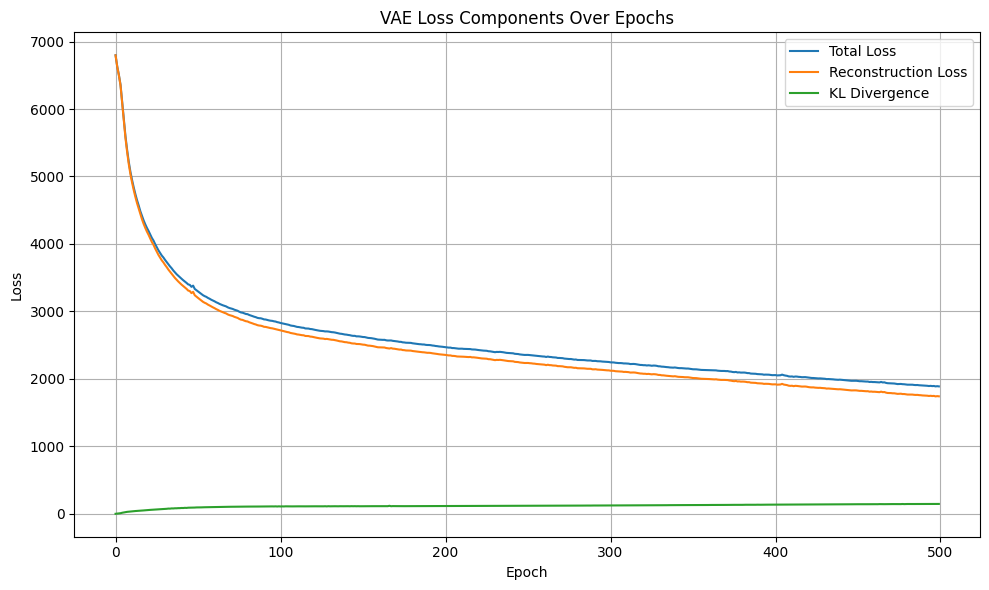

In [82]:
plt.figure(figsize=(10, 6))
plt.plot(total_loss_hist, label='Total Loss')
plt.plot(recon_loss_hist, label='Reconstruction Loss')
plt.plot(kld_loss_hist, label='KL Divergence')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('VAE Loss Components Over Epochs')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [83]:
model.eval()
with torch.no_grad():
    mu_all = []
    for i in range(X_tensor.shape[0]):
        x = torch.tensor(X_tensor[i], dtype=torch.float32).to(device).unsqueeze(0)
        mu, _ = model.encode(x)
        mu_all.append(mu.cpu().numpy().flatten())
mu_all = np.array(mu_all)
print('dim of latent mu:', mu_all.shape)

dim of latent mu: (331, 10)


/var/folders/br/nr4k1vxj1_j7jxk17x7xr8n9g2q0k8/T/ipykernel_93849/2362508139.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(X_tensor[i], dtype=torch.float32).to(device).unsqueeze(0)


In [84]:
# 2d-TSNE
z_2d = TSNE(n_components=2, perplexity=8).fit_transform(mu_all)

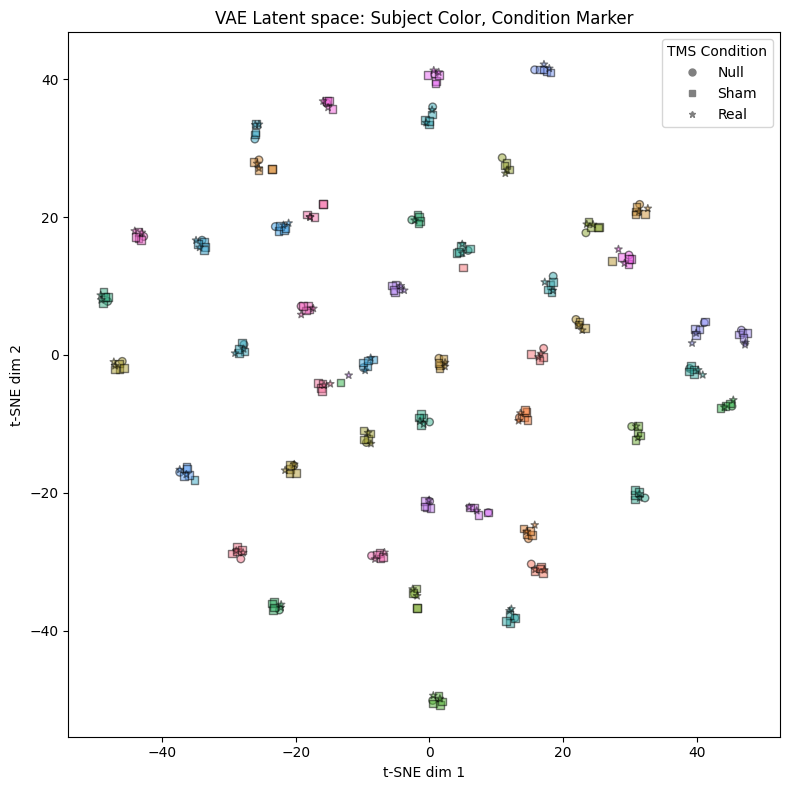

In [85]:
# Map 'N' = 0 (Null), 'S' = 1 (Sham), 'C' = 2 (Real/cTBS)
label_map = {'N': 0, 'S': 1, 'C': 2}
y = [label_map[t] for t in all_tms_type]
y = np.array(y).flatten()
unique_conds = np.unique(y)
markers = ['o', 's', '*']
cond_to_marker = {cond: markers[i] for i, cond in enumerate(unique_conds)}

subject_array = np.array(all_subject_id)
unique_subjects = np.unique(subject_array)
subject_to_idx = {subj: i for i, subj in enumerate(unique_subjects)}
subject_idx = np.array([subject_to_idx[subj] for subj in subject_array])

palette = sns.color_palette("husl", len(unique_subjects))  # 48 distinct hues
subject_colors = np.array([palette[i] for i in subject_idx])

# Plot each condition group with its marker and subject-based color
fig, ax = plt.subplots(figsize=(8, 8))

for cond in unique_conds:
    mask = y == cond
    ax.scatter(
        z_2d[mask, 0],
        z_2d[mask, 1],
        marker=cond_to_marker[cond],
        s=30, # marker size
        c=subject_colors[mask],
        label=f'Condition {cond}',
        edgecolors='k',
        alpha=0.5
    )
handles = [plt.Line2D([0], [0], marker=cond_to_marker[c], color='gray', linestyle='',
                      label={0: 'Null', 1: 'Sham', 2: 'Real'}[c],
                      markersize=5) for c in unique_conds]
ax.legend(handles=handles, title='TMS Condition', loc='upper right')

ax.set_title("VAE Latent space: Subject Color, Condition Marker")
ax.set_xlabel("t-SNE dim 1")
ax.set_ylabel("t-SNE dim 2")
plt.tight_layout()
plt.show()

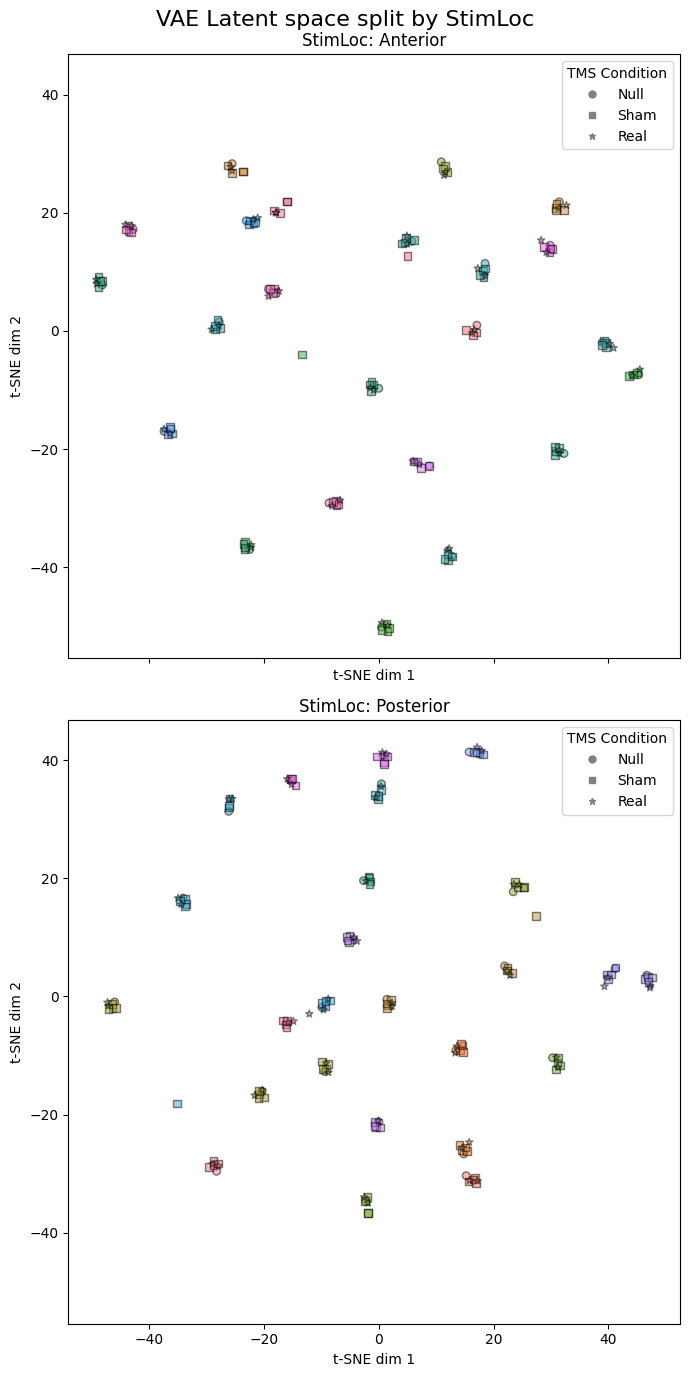

In [86]:
# Create stimloc mapping
stimlocs = ['Anterior', 'Posterior']

# Split by stimloc
fig, axes = plt.subplots(2, 1, figsize=(7, 14), sharex=True, sharey=True)

for i, loc in enumerate(stimlocs):
    ax = axes[i]
    ax.set_title(f"StimLoc: {loc}")

    for cond in unique_conds:
        mask = (y == cond) & (all_stimloc == loc)
        ax.scatter(
            z_2d[mask, 0],
            z_2d[mask, 1],
            marker=cond_to_marker[cond],
            s=30,
            c=subject_colors[mask],
            label=f'Condition {cond}',
            edgecolors='k',
            alpha=0.5
        )

    handles = [plt.Line2D([0], [0], marker=cond_to_marker[c], color='gray', linestyle='',
                          label={0: 'Null', 1: 'Sham', 2: 'Real'}[c],
                          markersize=5) for c in unique_conds]
    ax.legend(handles=handles, title='TMS Condition', loc='upper right')
    ax.set_xlabel("t-SNE dim 1")
    ax.set_ylabel("t-SNE dim 2")

fig.suptitle("VAE Latent space split by StimLoc", fontsize=16)
plt.tight_layout()
plt.show()


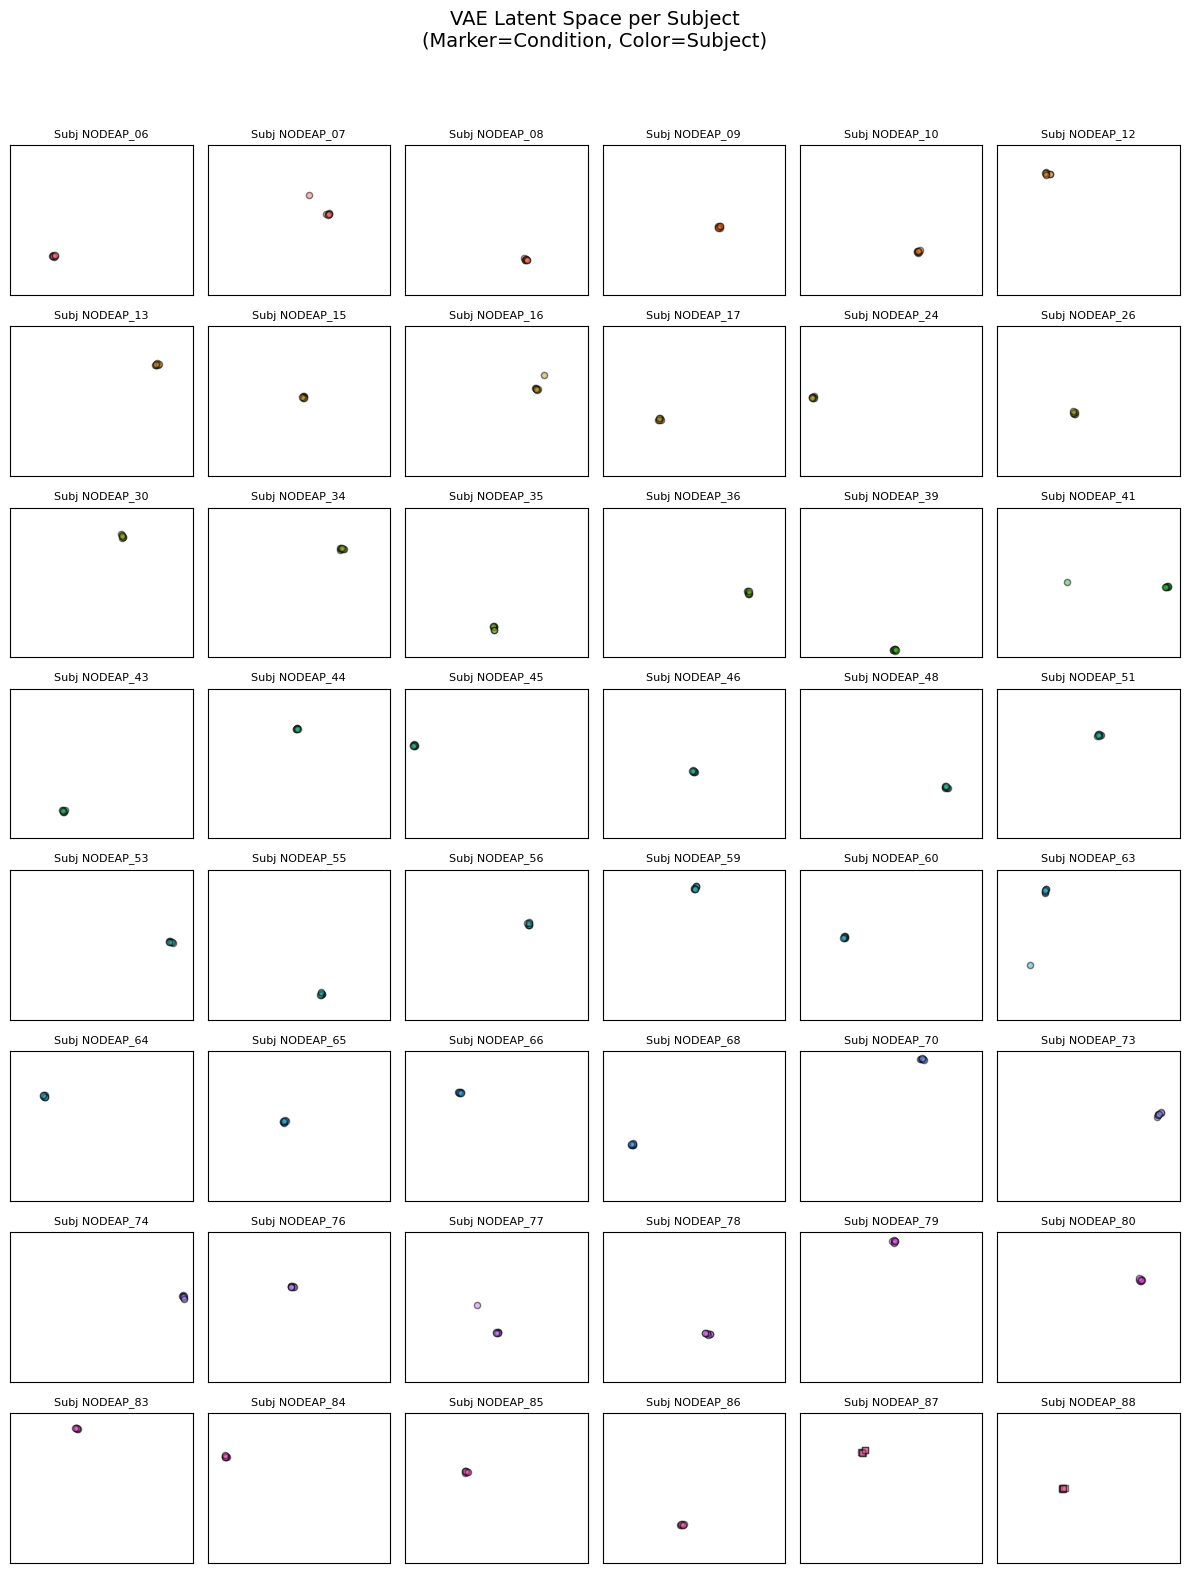

In [87]:
n_subjects = len(unique_subjects)
n_cols = 6
n_rows = int(np.ceil(n_subjects / n_cols))

fig, axs = plt.subplots(n_rows, n_cols, figsize=(n_cols * 2, n_rows * 2), sharex=True, sharey=True)
axs = axs.flatten()

for i, subj in enumerate(unique_subjects):
    ax = axs[i]
    subj_mask = subject_array == subj
    cond = y[subj_mask][0]  # assumes one condition per subject
    marker = cond_to_marker[cond]
    color = palette[subject_to_idx[subj]]

    ax.scatter(
        z_2d[subj_mask, 0],
        z_2d[subj_mask, 1],
        marker=marker,
        s=20,
        c=[color],
        edgecolors='k',
        alpha=0.5
    )
    ax.set_title(f'Subj {subj}', fontsize=8)
    ax.grid(True)
    ax.set_xticks([])
    ax.set_yticks([])

plt.suptitle("VAE Latent Space per Subject\n(Marker=Condition, Color=Subject)", fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


In [88]:
# Prepare your data
mu = np.array(mu_all)  # 331×10 latent variables
y = np.array([label_map[t] for t in all_tms_type])

unique_subjects = np.unique(all_subject_id)

# Store per-subject distances
results = []

for subj in unique_subjects:
    
    idx = all_subject_id == subj
    
    mu_subj = mu[idx]
    stimloc_subj = all_stimloc[idx]
    y_subj = y[idx]
    
    # Compute mean latent vectors for each condition (0, 1, 2)
    means = {}
    for cond in [0, 1, 2]:
        cond_mu = mu_subj[y_subj == cond]
        if len(cond_mu) > 0:
            means[cond] = np.mean(cond_mu, axis=0)
    
    # Only compute distances if all three conditions are present
    if all(c in means for c in [0, 1, 2]):
        d_0_1 = euclidean(means[0], means[1])
        d_0_2 = euclidean(means[0], means[2])
        results.append({
            "subject": subj,
            "stimloc": stimloc_array[idx],
            "d_null_sham": d_0_1,
            "d_null_real": d_0_2,
            "diff_real_minus_sham": d_0_2 - d_0_1
        })

# Convert to DataFrame
df = pd.DataFrame(results)

In [89]:
print(df)

      subject                                            stimloc  d_null_sham  \
0   NODEAP_06  [Posterior, Posterior, Posterior, Posterior, P...     8.818391   
1   NODEAP_07  [Anterior, Anterior, Anterior, Anterior, Anter...    14.254015   
2   NODEAP_08  [Posterior, Posterior, Posterior, Posterior, P...     7.958817   
3   NODEAP_09  [Posterior, Posterior, Posterior, Posterior, P...     6.455221   
4   NODEAP_10  [Posterior, Posterior, Posterior, Posterior, P...     6.198840   
5   NODEAP_12  [Anterior, Anterior, Anterior, Anterior, Anter...     8.552370   
6   NODEAP_13  [Anterior, Anterior, Anterior, Anterior, Anter...     7.975799   
7   NODEAP_15  [Posterior, Posterior, Posterior, Posterior, P...     4.057771   
8   NODEAP_16  [Posterior, Posterior, Posterior, Posterior, P...     8.124685   
9   NODEAP_17  [Posterior, Posterior, Posterior, Posterior, P...     4.800734   
10  NODEAP_24  [Posterior, Posterior, Posterior, Posterior, P...     6.097345   
11  NODEAP_26  [Posterior, P

In [72]:
# Print summary
print(df.describe())

       d_null_sham  d_null_real  diff_real_minus_sham
count    46.000000    46.000000             46.000000
mean      3.786034     4.168625              0.382591
std       1.321512     1.377024              0.983638
min       1.650285     1.883768             -2.349233
25%       2.922729     3.229793             -0.217421
50%       3.449297     3.778673              0.567142
75%       4.303986     4.828349              0.997805
max       7.112248     8.109967              1.980276


In [73]:
# Melt the dataframe to long format for seaborn
df_long = pd.melt(
    df,
    id_vars=["subject", "stimloc"],
    value_vars=["d_null_sham", "d_null_real"],
    var_name="Comparison",
    value_name="Distance"
)

# Rename for better display
df_long["Comparison"] = df_long["Comparison"].replace({
    "d_null_sham": "Null vs Sham",
    "d_null_real": "Null vs Real"
})
df_long

,subject,stimloc,Comparison,Distance
0,NODEAP_06,"[Posterior, Posterior, Posterior, Posterior, P...",Null vs Sham,3.663444
1,NODEAP_07,"[Anterior, Anterior, Anterior, Anterior, Anter...",Null vs Sham,3.610019
2,NODEAP_08,"[Posterior, Posterior, Posterior, Posterior, P...",Null vs Sham,3.429180
3,NODEAP_09,"[Posterior, Posterior, Posterior, Posterior, P...",Null vs Sham,3.586396
4,NODEAP_10,"[Posterior, Posterior, Posterior, Posterior, P...",Null vs Sham,2.530872
...,...,...,...,...
87,NODEAP_80,"[Anterior, Anterior, Anterior, Anterior, Anter...",Null vs Real,5.170069
88,NODEAP_83,"[Posterior, Posterior, Posterior, Posterior, P...",Null vs Real,3.468483
89,NODEAP_84,"[Anterior, Anterior, Anterior, Anterior, Anter...",Null vs Real,3.164919
90,NODEAP_85,"[Anterior, Anterior, Anterior, Anterior, Anter...",Null vs Real,3.152085


In [58]:
df_long.groupby(['stimloc', 'Comparison'])['Distance'].mean()

TypeError: unhashable type: 'numpy.ndarray'

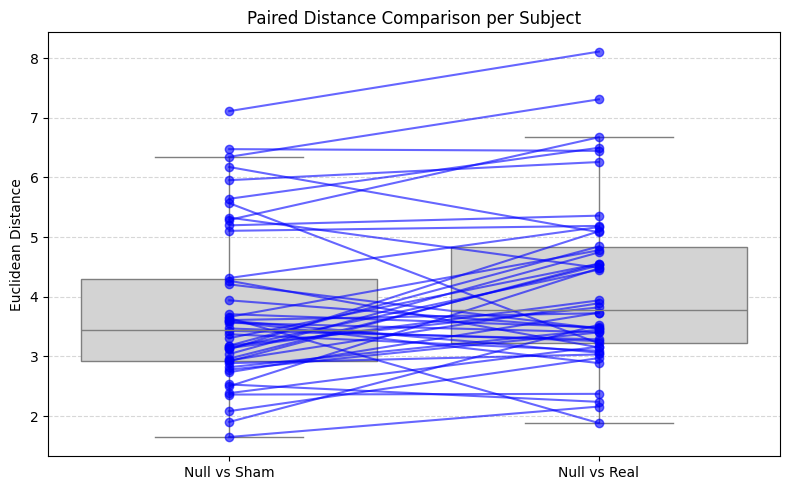

In [74]:
plt.figure(figsize=(8, 5))
sns.boxplot(data=df_long, x="Comparison", y="Distance", color="lightgray", showfliers=False)

# Overlay subject-level paired lines
for subj in df["subject"]:
    subj_data = df_long[df_long["subject"] == subj]
    plt.plot(
        subj_data["Comparison"],
        subj_data["Distance"],
        marker='o',
        linestyle='-',
        alpha=0.6,
        color='blue'
    )

plt.title("Paired Distance Comparison per Subject")
plt.ylabel("Euclidean Distance")
plt.xlabel("")
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

In [75]:
# Paired t-test
t_stat, p_val_t = ttest_rel(df["d_null_sham"], df["d_null_real"])
print(f"Paired t-test: t = {t_stat:.3f}, p = {p_val_t:.4f}")

# Optional: Non-parametric Wilcoxon signed-rank test
try:
    stat_w, p_val_w = wilcoxon(df["d_null_sham"], df["d_null_real"])
    print(f"Wilcoxon signed-rank test: W = {stat_w:.3f}, p = {p_val_w:.4f}")
except ValueError as e:
    print("Wilcoxon test error:", e)


Paired t-test: t = -2.638, p = 0.0114
Wilcoxon signed-rank test: W = 306.000, p = 0.0096


### if separating anterior and posterior group

In [ ]:
stimlocs = ['Anterior', 'Posterior']
fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=True)

for i, loc in enumerate(stimlocs):
    ax = axes[i]
    df_loc = df_long[df_long["stimloc"] == loc]
    
    # Draw boxplot
    sns.boxplot(data=df_loc, x="Comparison", y="Distance", color="lightgray", showfliers=False, ax=ax)

    # Draw lines for each subject
    for subj in df_loc["subject"].unique():
        subj_data = df_loc[df_loc["subject"] == subj]
        ax.plot(
            subj_data["Comparison"],
            subj_data["Distance"],
            marker='o',
            linestyle='-',
            alpha=0.6,
            color='blue'
        )

    ax.set_title(f"{loc} Subjects")
    ax.set_xlabel("")
    ax.grid(axis='y', linestyle='--', alpha=0.5)

axes[0].set_ylabel("Euclidean Distance")
plt.suptitle("Paired Distance Comparison per Subject by StimLoc", fontsize=14)
plt.tight_layout()
plt.show()


In [ ]:
for loc in ['Anterior', 'Posterior']:
    df_loc = df[df['stimloc'] == loc]
    
    print(f"\n--- {loc} ---")
    
    # Paired t-test
    t_stat, p_val_t = ttest_rel(df_loc["d_null_sham"], df_loc["d_null_real"])
    print(f"Paired t-test: t = {t_stat:.3f}, p = {p_val_t:.4f}")
    
    # Wilcoxon signed-rank test
    try:
        stat_w, p_val_w = wilcoxon(df_loc["d_null_sham"], df_loc["d_null_real"])
        print(f"Wilcoxon signed-rank test: W = {stat_w:.3f}, p = {p_val_w:.4f}")
    except ValueError as e:
        print("Wilcoxon test error:", e)
